# Introduction aux GSE RW : TP

Nous mettons en oeuvre dans ce notebook certains des éléments vus en séance concernant l'utilisation de Générateurs de Scénarios Economiques (GSE) dans la mesure monde réelle en assurance. 

Nous considérons une compagnie d'assurance qui souhaite investir les primes qu'elle perçoit dans un fond hybride correspondant à un indice action, à une obligation de maturité fixe (10A) et une partie monnétaire (capitalisée en continu).

En équation, la valeur du portefeuille à tout moment $t$ s'écrira de la manière suivante : 
$$
P_t = \alpha S_t + \beta P(t,t+10) + (1-\alpha-\beta) \text{Cash}_t
$$

où $\text{Cash}_t = e^{\int_0^{t} r_u \text{d} u}$, $S_t$ est la valeur de l'indice action à la date $t$ et $P(t,T)$ est le prix en date $t$ d'un Zéro-Coupon expirant en date $T \geq t$, $\alpha$, $\beta$ sont les pondérations associées à chaque type d'instrument. 

La compagnie souhaite mener une étude d'allocation optimale de son portefeuille d'investissement et ainsi qu'une étude de risque de solvabilité, liée à l'allocation finale retenue. Pour ce faire, l'assurance recourt à un GSE Monde-Réel qui produira des simulations de trajectoires de l'indice action $S$ et des Zéro-Coupons de maturité $M$. Grâce à ces simulations, il sera possible de simuler différents scénarios de valeur pour le portefeuille de l'assureur, en fonction du poids $\alpha$ retenu.

<b> Le but final de ce TP est de construire un GSE mesure Monde-Réelle permettant de déduire l'allocation optimale entre fond obligataire et action ; cela passe donc par un calibrage des modèles qui le composent, leur simulation puis la validation des trajectoires simulées. Dans ce TP, vous aurez à : </b>
* <b> répondre à des questions théoriques en utilisant le cours</b>, 
* <b> utiliser des fonctions déjà implémentées pour répondre aux questions</b>,
* <b> implémenter vos propres fonctions</b>,
* <b> proposer des améliorations, etc</b>.
    
<b> Le barême est donné à titre indicatif : pour avoir la note maximale, il n'est pas nécessaire de répondre à toutes les questions. En cas de note supérieure à 20, le surplus sera pris en compte en tant que bonus dans la notation finale. Toute prise d'initiative de votre part (commentaire, illustration, etc.) sera aussi valorisée. </b>

--------------------------------------------------------------------------------------------------------------
## <ins>Description des modèles</ins>

Le GSE est constitué de deux modèles : l'un permettant la simulation de trajectoires de taux (pour calculer des prix Zéro-Coupon *in fine*), le second permettant la simulation de trajectoires actions.

#### 1. <ins> Modèle de taux : le **G2** (*2-factor Gaussian*) <ins>

##### Spécification risque neutre

Nous choisissons un modèle de taux court dans lequel l'évolution du taux court non risqué $r$ est donnée par l'équation suivante : 
$$
    r_t = x_t + y_t, \\
$$

Nous commençons par exprimer la dynamique du taux court dans l'univers risque neutre. Nous voulons l'exprimer en monde réel dans la suite.

$$
    \text{d} x_t = - a_1 x_t \text{d} t + \sigma_1 \text{d} \widetilde{W}^1_t, x_0 = x,
$$

$$
    \text{d} y_t = - a_2 x_t \text{d} t + \sigma_2 \text{d} \widetilde{W}^2_t, y_0 = y,
$$

où : 
* $\widetilde{W}^1$ et $\widetilde{W}^2$ sont deux mouvements Browniens sous la mesure risque neutre $\mathbb{P}^*$, **corrélés**, tels que $\langle\widetilde{W}^1, \widetilde{W}^2 \rangle_t= \rho t$, avec $\rho \in [-1, 1]$,
* $a_1,a_2,\sigma_1, \sigma_2$ sont des **paramètres positifs**,
* $x,y$ sont des paramètres réels.

##### Expression des prix Zéro-Coupon
Dans ce modèle de taux court, le déflateur entre les dates $s$ et $t$ ($s \leq t$) se calcule comme :
$$
    D(s,t) = \exp \Big( - \int_s^t r_u \text{d} u \Big).
$$

En notant $\mathcal{F}_t$ la filtration générée par le processus de taux court $r$ jusqu'à la date $t$, on montre également que le **prix d'un Zéro-Coupon à la date $t$, de maturité $T$, s'exprime dans ce modèle** avec la formule théorique suivante : 
 $$
    P^{\text{Mod}}(t, T ; a_1,a_2,\sigma_1, \sigma_2)=\mathbb{E}^*[D(t, T) | \mathcal{F}_t] = \exp \Big( - B(T - t;a_1) x_t - B(T - t;a_2) y_t - \frac{1}{2} A(T - t;a_1,a_2,\sigma_1, \sigma_2, \rho) \Big),
 $$

 où : 

 * $A(\tau;a_1,a_2,\sigma_1, \sigma_2, \rho) = \sum_{i=1}^2\frac{\sigma_i^2}{a_i^2} \Big( \tau + \frac{2}{a_i} e^{-a_i\tau} - \frac{e^{-2a_i\tau}}{2 a_i} - \frac{3}{2 a_i} \Big) \Big) + 2 \rho \frac{\sigma_1 \sigma_2}{a_1 a_2} \big( \tau - B(\tau;a_1) - B(\tau;a_2) + B(\tau;a_1+a_2) \big)$ ,
 * $B(\tau;a) = \frac{1-e^{-a\tau}}{a}$.

##### Passage en univers monde réel
Nous écrivons les formules de passage suivantes:
$$
    d\widetilde{W}^i_t = dW^i_t + \gamma_i d t, i = 1, 2
$$
où :
* $\gamma_i, i = 1, 2$ sont deux paramètres constants, permettant la définition des mouvements browniens sous la probabilité monde réelle. Ils sont aussi notées **primes de risque**.
* $W^1$ et $W^2$ sont deux mouvements Browniens sous la mesure monde réelle $\mathbb{P}$. Nous avons aussi $\langle{W}^1, {W}^2 \rangle_t= \rho t$.

Ainsi, nous pouvons exprimer la dynamique du modèle dans l'univers monde réel :
$$
r_t = x_t + y_t,
$$ 

$$
\text{d} x_t = - a_1 x_t \text{d} t + \sigma_1 \gamma_1 \text{d} t + \sigma_1 \text{d} W^1_t, x_0=x,\\
$$

$$
\text{d} y_t = - a_2 y_t \text{d} t + \sigma_2 \gamma_2 \text{d} t + \sigma_2 \text{d} W^2_t, y_0=y.
$$

#### 2. <ins> Modèle action <ins>

Nous choisissons de représenter l'évolution de l'indice action selon la dynamique 
$$
\text{d} S_t = S_t \big( \mu(t) \text{d} t + \sigma(t) \text{d} B_t \big), S_0 = 1
$$
    
où : 
* $t \mapsto \mu(t)$ et $t \mapsto \sigma(t)$ sont deux fonctions déterministes, supposées suffisamment régulières pour réaliser les calculs nécessaires dans ce TP, 
* $B$ est un mouvement Brownien corrélé à $W^1$ et $W^2$,
* $S$ représente la valeur de l'indice action.

Nous noterons $\mathcal{F}_t$ l'information de marché disponible au temps $t$ ; mathématiquement, il s'agit de la tribu générée par les mouvements Browniens $\mathcal{F}_t = \sigma \big( (B_u)_{u \leq t}, (\widetilde{W}^1_u)_{u \leq t}, (\widetilde{W}^2_u)_{u \leq t} \big)$. 

**Par défaut, dans ce TP, nous considérerons les fonctions de tendance et de diffusion constantes : $\mu(t) \equiv \mu \in \mathbb{R}_+$ et $\sigma(t) \equiv \sigma \in \mathbb{R}_+$**.

--------------------------------------------------------------------------------------------------------------
### Question 1 (2 pts) : 

Afin de justifier la formule du prix Zéro-Coupon, nous souhaitons expliciter la loi de la variable aléatoire $ ( - \int_t^T r_u \text{d} u )$.

En utilisant la spécification risque neutre, pour tout $T \geq t \geq 0$, **justifier** les expressions suivantes :
$$ 
x_T = x_t e^{- a_1 (T-t)} + \sigma_1 \int_t^T e^{- a_1 (T-u)} \text{d} \widetilde{W}^1_u, 
$$
$$
y_T = y_t e^{- a_2 (T-t)} + \sigma_2 \int_t^T e^{- a_2 (T-u)} \text{d} \widetilde{W}^2_u.
$$

**En déduire** que :

$$ 
\int_t^T x_u \text{d} u = x_t B(T-t;a_1) + \sigma_1 \int_t^T B(T-u;a_1) \text{d} \widetilde{W}^1_u,
$$

$$
\int_t^T y_u \text{d} u = y_t B(T-t;a_2) + \sigma_2 \int_t^T B(T-u;a_2) \text{d} \widetilde{W}^2_u.
$$

**Conclure** que la loi de  $(- \int_t^T r_u \text{d} u )$ conditionnellement à $\mathcal{F}_t$ est une loi normale et donner ses paramètres.

La formule théorique du prix Zéro-Coupon est ensuite obtenue en explicitant les calculs des intégrales ci-dessus, et en calculant $\mathbb{E}^*[e^{- \int_t^T r_u \text{d} u} | \mathcal{F}_t]$ comme une transformée de Laplace d'une loi normale.

--------------------------------------------------------------------------------------------------------------

Nous voulons déterminer la loi de :

$$
- \int_t^T r_u \text{d} u.
$$

En utilisant la spécification sous la mesure risque neutre, nous avons :

$$
r_t = x_t + y_t.
$$

Les dynamiques de $ x_t $ et $ y_t $ sont données par les équations différentielles stochastiques suivantes :

$$
\text{d} x_t = - a_1 x_t \text{d} t + \sigma_1 \text{d} \widetilde{W}^1_t,
$$

$$
\text{d} y_t = - a_2 y_t \text{d} t + \sigma_2 \text{d} \widetilde{W}^2_t.
$$

où $ \widetilde{W}^1_t $ et $ \widetilde{W}^2_t $ sont deux mouvements browniens sous la mesure risque neutre $ \mathbb{P}^* $, corrélés avec :

$$
\langle \widetilde{W}^1, \widetilde{W}^2 \rangle_t = \rho t.
$$



### **1. Résolution des équations différentielles stochastiques**  

Nous avons affaire à des **équations différentielles stochastiques linéaires**, qui se résolvent par la **méthode du facteur intégrant**.


L'équation différentielle est :

$$
\text{d} x_t = - a_1 x_t \text{d} t + \sigma_1 \text{d} \widetilde{W}^1_t.
$$

Multipliant par le facteur intégrant $ e^{a_1 t} $ :

$$
e^{a_1 t} \text{d} x_t + a_1 e^{a_1 t} x_t \text{d} t = \sigma_1 e^{a_1 t} \text{d} \widetilde{W}^1_t.
$$

Ce qui revient à écrire :

$$
\text{d} (e^{a_1 t} x_t) = \sigma_1 e^{a_1 t} \text{d} \widetilde{W}^1_t.
$$

En intégrant entre $ t $ et $ T $ :

$$
e^{a_1 T} x_T - e^{a_1 t} x_t = \sigma_1 \int_t^T e^{a_1 u} \text{d} \widetilde{W}^1_u.
$$

D'où :

$$
x_T = x_t e^{- a_1 (T-t)} + \sigma_1 \int_t^T e^{- a_1 (T-u)} \text{d} \widetilde{W}^1_u.
$$


De manière analogue, on trouve :

$$
y_T = y_t e^{- a_2 (T-t)} + \sigma_2 \int_t^T e^{- a_2 (T-u)} \text{d} \widetilde{W}^2_u.
$$


### **2. Calcul des intégrales de $ x_t $ et $ y_t $**

Nous calculons maintenant :

$$
\int_t^T x_u \text{d} u.
$$

En utilisant la décomposition de $ x_u $ :

$$
x_u = x_t e^{- a_1 (u-t)} + \sigma_1 \int_t^u e^{- a_1 (u-v)} \text{d} \widetilde{W}^1_v.
$$

On intègre terme à terme :

$$
\int_t^T x_u \text{d} u = x_t \int_t^T e^{- a_1 (u-t)} \text{d} u + \sigma_1 \int_t^T \int_t^u e^{- a_1 (u-v)} \text{d} \widetilde{W}^1_v \text{d} u.
$$

Or, on sait que :

$$
\int_t^T e^{- a_1 (u-t)} \text{d} u = \frac{1 - e^{- a_1 (T-t)}}{a_1} = B(T-t; a_1).
$$

Ainsi,

$$
\int_t^T x_u \text{d} u = x_t B(T-t;a_1) + \sigma_1 \int_t^T B(T-u;a_1) \text{d} \widetilde{W}^1_u.
$$

De même, pour $ y_u $, on obtient :

$$
\int_t^T y_u \text{d} u = y_t B(T-t;a_2) + \sigma_2 \int_t^T B(T-u;a_2) \text{d} \widetilde{W}^2_u.
$$


### **3. Loi de** $ - \int_t^T r_u \text{d} u $

On a :

$$
- \int_t^T r_u \text{d} u = - \int_t^T (x_u + y_u) \text{d} u.
$$

D'où :

$$
- \int_t^T r_u \text{d} u = - \left( x_t B(T-t;a_1) + y_t B(T-t;a_2) \right) - \sigma_1 \int_t^T B(T-u;a_1) \text{d} \widetilde{W}^1_u - \sigma_2 \int_t^T B(T-u;a_2) \text{d} \widetilde{W}^2_u.
$$

Les intégrales stochastiques sont des variables normales conditionnellement à $ \mathcal{F}_t $. Ainsi,

$$
- \int_t^T r_u \text{d} u \sim \mathcal{N} \left( - (x_t B(T-t;a_1) + y_t B(T-t;a_2)), \sigma^2 \right).
$$

Avec :

$$
\sigma^2 = \sigma_1^2 \int_t^T B^2(T-u; a_1) \text{d} u + \sigma_2^2 \int_t^T B^2(T-u; a_2) \text{d} u + 2 \rho \sigma_1 \sigma_2 \int_t^T B(T-u; a_1) B(T-u; a_2) \text{d} u.
$$


### **4. Prix du Zéro-Coupon**

Le prix du Zéro-Coupon est donné par :

$$
P(t,T) = \mathbb{E}^*\left[e^{- \int_t^T r_u \text{d} u} \mid \mathcal{F}_t \right].
$$

Puisque $ - \int_t^T r_u \text{d} u $ suit une loi normale, on utilise la transformée de Laplace d'une variable gaussienne :

$$
P(t,T) = e^{\mu + \frac{1}{2} \sigma^2},
$$

où :

$$
\mu = - (x_t B(T-t;a_1) + y_t B(T-t;a_2)).
$$


### **Conclusion**

Nous avons montré que :

$$
- \int_t^T r_u \text{d} u \sim \mathcal{N} \left( - (x_t B(T-t;a_1) + y_t B(T-t;a_2)), \sigma^2 \right).
$$

Cela permet d'obtenir le prix du Zéro-Coupon sous la mesure risque neutre par la transformée de Laplace d'une loi normale.

--------------------------------------------------------------------------------------------------------------
### Question 2 (1 pt) : 

Quelle convention de définition des taux ZC est la plus commmode à utiliser dans le modèle de taux choisi ? 
Donner alors l'expression des taux ZC induits par le modèle, notés 

$$
R^{\text{Mod}}(t,T ; a_1, a_2, \sigma_1, \sigma_2).
$$

--------------------------------------------------------------------------------------------------------------

### **Question 2 : Convention des taux Zéro-Coupon et expression des taux induits**  

#### **1. Choix de la convention des taux Zéro-Coupon**  

Dans notre modèle, le prix d’un **Zéro-Coupon** de maturité $ T $ est donné par :  

$$
P(t,T) = \mathbb{E}^* \left[ e^{- \int_t^T r_u \text{d} u} \mid \mathcal{F}_t \right].
$$

La convention de définition des taux Zéro-Coupon la plus **commode** est celle du **taux actuariel en capitalisation continue**. Ce taux, noté $ R^{\text{Mod}}(t,T) $, est défini par :  

$$
P(t,T) = e^{- (T-t) R^{\text{Mod}}(t,T)}.
$$

Cette convention est naturelle car elle permet d’exprimer directement le taux en fonction du prix obligataire et de simplifier les calculs de valorisation d’obligations.


#### **2. Expression des taux Zéro-Coupon induits par le modèle**  

En prenant le logarithme de la formule du prix :

$$
R^{\text{Mod}}(t,T) = -\frac{1}{T-t} \ln P(t,T).
$$

D'après la question précédente, le prix du Zéro-Coupon est donné par :

$$
P(t,T) = e^{\mu + \frac{1}{2} \sigma^2},
$$

où :

$$
\mu = - (x_t B(T-t;a_1) + y_t B(T-t;a_2)).
$$

$$
\sigma^2 = \sigma_1^2 \int_t^T B^2(T-u; a_1) \text{d} u + \sigma_2^2 \int_t^T B^2(T-u; a_2) \text{d} u + 2 \rho \sigma_1 \sigma_2 \int_t^T B(T-u; a_1) B(T-u; a_2) \text{d} u.
$$

En prenant le logarithme :

$$
R^{\text{Mod}}(t,T) = \frac{x_t B(T-t;a_1) + y_t B(T-t;a_2)}{T-t} - \frac{1}{2 (T-t)} \sigma^2.
$$

Ainsi, les taux Zéro-Coupon induits par le modèle sont donnés par :

$$
R^{\text{Mod}}(t,T; a_1, a_2, \sigma_1, \sigma_2) = \frac{x_t B(T-t;a_1) + y_t B(T-t;a_2)}{T-t} - \frac{1}{2 (T-t)} \sigma^2.
$$

## <ins>Implémentation</ins>

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### <ins>Données à disposition pour le calibrage</ins> 

L'univers de modélisation étant celui du monde réel, le calibrage des modèles nécéssite des historiques de données. Ces données sont à présents fournies, elles sont composées : 
* D'une courbe de taux de maturités allant de 1 à 120 ans  ; 
* D'un historique de données de taux swaps de maturité 1 an, 5 ans, et 10 ans ; 
* D'un historique des valeurs d'une indice action dont on souhaite répliquer le comportement.

In [2]:
donnees_marche = pd.DataFrame(
    {
        # Courbe de taux Zéro-Coupon
        'Maturites taux': range(1, 121),
        'ZCR': [-0.0050, -0.0042, -0.0027, -0.00132, -0.0005, 
                0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.0040, 0.0045, 
                0.0050, 0.0055, 0.0060, 0.0065, 0.0070, 0.0075, 0.0080, 0.0085, 0.0090, 0.0095, 
                0.0100, 0.0105, 0.0110, 0.0115, 0.0120, 0.0125, 0.0130, 0.0135, 0.0140, 0.0145, 
                0.0150, 0.0155, 0.0160, 0.0165, 0.0170, 0.0175, 0.0180, 0.0185, 0.0190, 0.0195, 
                0.0200, 0.0205, 0.0210, 0.0215, 0.0220, 0.0225, 0.0230, 0.0235, 0.0240, 0.0245, 
                0.0250, 0.0255, 0.0260, 0.0265, 0.0270, 0.0275, 0.0280, 0.0285, 0.0290, 0.0295, 
                0.0300, 0.0305, 0.0310, 0.0315, 0.0320, 0.0325, 0.0330, 0.0335, 0.0340, 0.0345, 
                0.0350, 0.0355, 0.0360, 0.0365, 0.0370, 0.0375, 0.0380, 0.0385, 0.0390, 0.0395, 
                0.0400, 0.0405, 0.0410, 0.0415, 0.0420, 0.0425, 0.0430, 0.0435, 0.0440, 0.0445, 
                0.0450, 0.0455, 0.0460, 0.0465, 0.0470, 0.0475, 0.0480, 0.0485, 0.0490, 0.0495, 
                0.0500, 0.0505, 0.0510, 0.0515, 0.0520, 0.0525, 0.0530, 0.0535, 0.0540, 0.0543, 
                0.0545, 0.05452, 0.05455, 0.05456, 0.0549]
    }
)

delta_hist = 1/12

donnees_histo = pd.DataFrame(
    {
        'Dates': pd.date_range(start='1998-10-31',  freq='M', periods=302),
        'Action': [1.0, 1.021708, 1.147140, 1.168508, 1.125962, 1.148273, 1.232497, 1.173888, 1.293519, 1.238690, 1.222594, 1.191685, 1.251196, 1.289055, 1.303943, 1.292041, 1.268963, 1.290611, 1.318527, 1.302470, 1.277972, 1.339024, 1.351968, 1.240102, 1.274948, 1.173057, 1.237838, 1.231953, 1.115098, 1.064025, 1.091604, 1.146324, 1.117478, 1.110679, 1.038109, 0.905495, 0.961842, 1.008001, 1.077209, 1.017164, 0.956318, 0.990372, 0.972933, 0.924993, 0.876631, 0.841074, 0.819142, 0.740967, 0.801749, 0.817102, 0.833085, 0.782709, 0.790557, 0.765427, 0.789970, 0.859527, 0.863535, 0.893673, 0.916777, 0.916992, 0.919060, 0.980318, 1.043786, 1.057461, 1.020862, 1.026825, 1.005259, 0.995348, 1.059147, 1.012225, 1.015403, 1.051834, 0.979953, 1.039001, 1.052211, 1.075807, 1.126012, 1.057898, 1.036044, 1.039059, 1.074510, 1.121749, 1.072571, 1.126821, 1.136730, 1.090165, 1.087304, 1.102340, 1.146937, 1.179268, 1.220326, 1.191086, 1.160486, 1.120495, 1.195395, 1.151661, 1.275183, 1.285950, 1.283455, 1.356154, 1.293156, 1.294476, 1.275578, 1.417146, 1.304049, 1.309558, 1.385914, 1.329568, 1.392277, 1.373189, 1.350962, 1.254248, 1.253898, 1.212617, 1.293793, 1.318221, 1.169732, 1.137418, 1.104490, 1.024011, 0.882345, 0.813606, 0.790488, 0.728754, 0.679331, 0.735397, 0.765600, 0.794046, 0.801866, 0.888292, 0.961059, 0.997085, 0.937059, 1.034799, 0.987641, 0.954647, 1.036176, 1.052669, 1.086989, 0.995396, 0.974256, 0.990491, 0.920913, 1.011959, 1.041888, 1.066337, 1.108474, 1.207880, 1.236648, 1.153740, 1.271740, 1.255025, 1.153128, 1.202001, 1.080367, 0.994926, 1.141685, 1.080721, 1.099639, 1.217907, 1.195895, 1.318972, 1.256397, 1.143805, 1.268482, 1.235583, 1.307638, 1.301033, 1.250063, 1.296126, 1.287853, 1.324282, 1.335229, 1.431732, 1.413515, 1.404614, 1.467433, 1.462440, 1.513105, 1.455317, 1.622764, 1.648435, 1.596167, 1.590256, 1.599900, 1.687724, 1.756467, 1.751330, 1.828149, 1.818894, 1.834466, 1.747089, 1.807350, 1.897965, 1.799774, 1.731511, 1.844278, 1.776421, 1.859457, 1.873869, 1.900715, 1.936815, 1.785370, 1.709194, 1.813653, 1.914137, 1.795602, 1.828262, 1.763651, 1.807004, 1.843664, 1.905605, 1.874714, 1.906421, 1.916218, 1.944793, 1.841011, 1.921154, 2.098569, 2.096296, 2.078536, 2.054386, 2.063732, 2.266567, 2.174199, 2.318064, 2.150758, 2.286936, 2.280688, 2.495383, 2.304205, 2.627398, 2.479250, 2.382279, 2.311819, 2.532815, 2.446470, 2.498269, 2.554115, 2.503163, 2.335946, 2.449859, 2.193789, 2.327202, 2.529246, 2.633282, 2.646822, 2.413937, 2.615075, 2.695171, 2.538196, 2.787507, 2.609388, 2.816960, 2.834433, 2.880110, 2.728976, 2.257055, 2.681343, 2.803316, 2.657380, 2.815610, 3.050257, 2.951727, 2.963875, 3.138828, 3.293871, 3.447785, 3.328807, 3.435469, 3.936023, 3.607360, 3.879165, 4.056201, 4.129867, 3.697315, 4.191581, 4.071825, 4.449457, 4.022487, 4.061268, 4.260599, 3.857558, 3.563541, 3.339405, 3.609010, 3.480336, 3.310201, 3.579168, 3.727054, 3.578009, 3.715544, 3.658864, 3.745633, 3.895036, 3.895514, 3.917265, 4.107816, 3.887123, 3.988514, 3.858608, 3.952464],
        'Taux 1A': [0.047884, 0.049847, 0.049682, 0.050510, 0.051925, 0.050792, 0.050935, 0.056282, 0.057863, 0.058584, 0.058768, 0.059284, 0.062716, 0.061711, 0.064880, 0.066900, 0.066219, 0.067577, 0.070260, 0.072631, 0.071496, 0.068455, 0.067330, 0.064208, 0.064010, 0.063959, 0.057122, 0.050552, 0.047044, 0.045566, 0.043525, 0.041946, 0.041852, 0.036929, 0.038440, 0.026729, 0.024724, 0.023968, 0.023773, 0.024349, 0.023991, 0.030473, 0.028604, 0.026243, 0.022620, 0.020441, 0.019703, 0.016251, 0.016927, 0.017317, 0.014365, 0.014243, 0.014697, 0.014410, 0.014814, 0.009831, 0.010766, 0.012542, 0.014791, 0.013927, 0.016707, 0.015896, 0.014567, 0.016267, 0.015489, 0.014130, 0.018738, 0.029683, 0.024300, 0.025011, 0.022480, 0.024538, 0.024387, 0.030632, 0.031140, 0.030871, 0.034903, 0.035034, 0.036330, 0.037385, 0.037595, 0.041131, 0.039624, 0.045311, 0.047777, 0.047088, 0.047581, 0.049469, 0.049044, 0.050552, 0.052809, 0.053835, 0.055773, 0.054104, 0.053105, 0.051149, 0.053955, 0.052804, 0.051190, 0.051885, 0.052875, 0.053068, 0.052396, 0.056201, 0.053411, 0.052712, 0.049443, 0.046237, 0.046744, 0.042656, 0.040173, 0.027895, 0.028119, 0.023163, 0.029685, 0.030117, 0.030897, 0.029303, 0.031095, 0.032450, 0.024397, 0.019624, 0.012789, 0.012013, 0.013420, 0.013849, 0.010448, 0.009931, 0.010477, 0.009811, 0.006532, 0.006008, 0.005921, 0.005571, 0.007519, 0.003671, 0.004680, 0.006025, 0.007147, 0.014604, 0.007621, 0.004727, 0.005749, 0.005966, 0.004818, 0.005347, 0.003973, 0.005610, 0.005828, 0.005346, 0.003444, 0.004388, 0.005564, 0.004270, 0.005563, 0.005341, 0.005544, 0.008561, 0.007058, 0.005490, 0.005683, 0.003462, 0.006278, 0.006059, 0.005883, 0.004292, 0.004453, 0.004416, 0.003937, 0.002905, 0.002601, 0.003152, 0.003763, 0.002502, 0.004085, 0.004512, 0.004614, 0.003481, 0.004802, 0.003165, 0.004516, 0.001854, 0.003772, 0.002421, 0.003524, 0.002158, 0.003953, 0.002655, 0.003525, 0.003729, 0.001514, 0.004695, 0.004616, 0.002306, 0.008092, 0.002224, 0.003330, 0.006185, 0.003806, 0.006388, 0.003751, 0.005354, 0.005386, 0.005659, 0.004586, 0.008363, 0.008752, 0.007315, 0.007005, 0.006895, 0.007523, 0.009915, 0.005594, 0.007115, 0.008964, 0.009430, 0.008654, 0.010769, 0.011424, 0.010686, 0.015197, 0.015294, 0.012285, 0.015243, 0.016133, 0.014996, 0.014461, 0.014741, 0.015977, 0.020198, 0.019211, 0.020536, 0.023934, 0.025497, 0.025832, 0.024143, 0.024104, 0.024432, 0.025360, 0.027457, 0.029837, 0.029315, 0.027573, 0.026122, 0.028545, 0.025810, 0.024683, 0.024589, 0.021425, 0.021137, 0.017244, 0.020447, 0.017050, 0.017580, 0.017636, 0.014550, 0.010543, 0.008886, 0.003808, 0.003926, 0.003544, 0.001868, 0.002970, 0.003229, 0.002815, 0.001293, 0.002197, 0.002713, 0.003559, 0.002118, 0.002785, 0.002308, 0.002681, 0.003900, 0.002394, 0.000828, 0.004318, 0.003493, 0.006073, 0.008923, 0.013645, 0.020396, 0.024895, 0.024587, 0.031466, 0.033386, 0.039114, 0.044430, 0.050005, 0.050188, 0.048238, 0.047965, 0.055581, 0.050450, 0.049067, 0.053421, 0.054819, 0.055110, 0.058254, 0.055703, 0.056149, 0.051095],
        'Taux 5A': [0.052215, 0.051531, 0.051998, 0.052339, 0.055890, 0.054971, 0.057313, 0.060554, 0.066739, 0.063630, 0.064240, 0.065024, 0.068835, 0.068040, 0.067846, 0.069661, 0.070734, 0.070767, 0.071130, 0.074846, 0.070006, 0.071533, 0.066894, 0.065200, 0.067148, 0.063926, 0.058225, 0.056283, 0.054389, 0.053131, 0.055628, 0.055827, 0.059393, 0.050565, 0.049776, 0.046066, 0.043148, 0.048898, 0.049351, 0.049989, 0.046647, 0.052553, 0.049596, 0.047839, 0.046644, 0.042160, 0.037784, 0.033138, 0.033767, 0.039732, 0.032928, 0.034688, 0.030418, 0.033048, 0.031473, 0.029039, 0.027833, 0.038407, 0.041172, 0.034927, 0.035958, 0.037513, 0.037265, 0.035479, 0.035643, 0.031504, 0.041521, 0.043772, 0.043570, 0.042920, 0.039095, 0.038215, 0.037483, 0.042029, 0.039544, 0.040029, 0.044682, 0.045337, 0.044187, 0.041771, 0.040744, 0.047246, 0.042815, 0.045431, 0.050096, 0.050448, 0.048618, 0.049096, 0.049893, 0.053092, 0.054247, 0.055665, 0.055871, 0.054326, 0.051486, 0.050382, 0.049945, 0.050677, 0.049990, 0.051981, 0.050997, 0.049312, 0.049749, 0.052555, 0.054653, 0.051516, 0.048788, 0.047242, 0.048087, 0.040167, 0.042065, 0.036389, 0.032600, 0.032248, 0.037165, 0.043240, 0.041941, 0.040628, 0.041437, 0.040601, 0.039045, 0.027824, 0.021702, 0.026788, 0.026723, 0.023474, 0.026116, 0.029382, 0.030928, 0.027656, 0.027244, 0.027123, 0.027991, 0.023600, 0.029761, 0.025147, 0.026752, 0.027140, 0.027903, 0.023865, 0.019090, 0.019417, 0.018220, 0.015171, 0.015311, 0.016682, 0.021609, 0.020926, 0.024175, 0.024199, 0.024059, 0.020598, 0.019465, 0.017339, 0.013341, 0.012641, 0.011893, 0.012912, 0.012450, 0.010479, 0.012206, 0.013627, 0.012364, 0.010422, 0.011793, 0.006943, 0.010175, 0.008210, 0.010434, 0.008499, 0.008477, 0.009224, 0.008659, 0.011293, 0.009251, 0.013425, 0.015999, 0.016350, 0.017427, 0.016007, 0.014360, 0.017550, 0.018680, 0.017615, 0.015997, 0.020813, 0.016283, 0.017351, 0.017018, 0.018059, 0.017943, 0.020066, 0.016845, 0.017020, 0.018804, 0.014748, 0.017792, 0.014898, 0.014278, 0.018294, 0.018707, 0.017591, 0.016719, 0.015374, 0.014925, 0.016306, 0.018334, 0.013816, 0.012400, 0.010576, 0.014361, 0.013135, 0.010950, 0.010794, 0.011614, 0.011587, 0.016231, 0.017106, 0.019075, 0.021342, 0.019441, 0.021316, 0.021162, 0.019126, 0.018085, 0.019065, 0.019378, 0.020127, 0.021517, 0.022696, 0.023529, 0.025642, 0.025436, 0.025389, 0.031096, 0.028200, 0.028774, 0.029807, 0.028903, 0.031276, 0.030112, 0.029502, 0.028208, 0.025090, 0.027415, 0.023746, 0.023419, 0.018902, 0.018713, 0.018597, 0.012753, 0.015996, 0.015148, 0.016231, 0.016991, 0.013463, 0.011782, 0.005358, 0.004234, 0.003824, 0.004019, 0.002524, 0.003543, 0.005130, 0.004978, 0.004344, 0.007332, 0.005480, 0.007518, 0.011540, 0.009606, 0.010138, 0.011725, 0.006808, 0.008576, 0.011501, 0.013970, 0.012824, 0.013953, 0.016100, 0.019725, 0.026336, 0.029387, 0.028781, 0.030420, 0.028672, 0.034987, 0.040794, 0.043053, 0.037056, 0.038648, 0.034694, 0.041330, 0.036882, 0.036058, 0.036724, 0.042906, 0.040611, 0.040951, 0.045235, 0.049739, 0.041360],
        'Taux 10A': [0.053417, 0.055923, 0.053919, 0.053900, 0.060459, 0.060385, 0.059567, 0.063168, 0.064970, 0.068909, 0.070969, 0.066493, 0.069081, 0.068445, 0.071609, 0.074035, 0.072052, 0.069671, 0.071116, 0.074303, 0.070431, 0.070397, 0.066994, 0.066956, 0.067542, 0.064716, 0.058835, 0.058944, 0.056842, 0.058501, 0.060845, 0.060854, 0.063463, 0.058161, 0.055692, 0.052946, 0.050777, 0.055503, 0.057226, 0.056558, 0.054774, 0.060189, 0.056531, 0.055030, 0.056764, 0.052459, 0.047211, 0.043220, 0.046457, 0.047433, 0.044307, 0.045646, 0.043579, 0.045476, 0.045011, 0.037709, 0.040203, 0.050478, 0.051011, 0.045413, 0.050186, 0.047856, 0.048651, 0.047588, 0.045598, 0.043991, 0.051097, 0.053154, 0.052493, 0.051389, 0.047361, 0.045906, 0.046001, 0.047156, 0.047160, 0.046364, 0.048096, 0.049693, 0.045714, 0.043069, 0.042484, 0.049189, 0.045068, 0.048407, 0.049820, 0.051232, 0.049082, 0.049132, 0.050543, 0.052658, 0.055325, 0.056685, 0.055320, 0.055646, 0.051240, 0.050665, 0.050731, 0.049146, 0.054609, 0.051263, 0.051255, 0.052519, 0.050881, 0.055717, 0.057456, 0.053151, 0.051028, 0.050625, 0.050487, 0.045685, 0.046685, 0.041898, 0.043556, 0.040984, 0.042817, 0.048687, 0.047174, 0.047465, 0.044169, 0.044523, 0.046697, 0.029589, 0.026675, 0.031076, 0.034999, 0.028857, 0.034327, 0.037187, 0.037714, 0.039391, 0.038231, 0.034085, 0.036090, 0.034669, 0.042613, 0.038214, 0.037996, 0.038452, 0.038782, 0.035377, 0.030879, 0.030327, 0.026383, 0.026276, 0.029034, 0.030578, 0.035180, 0.038158, 0.036781, 0.037297, 0.034377, 0.034693, 0.035047, 0.030732, 0.023860, 0.023738, 0.023923, 0.023270, 0.021377, 0.021439, 0.020081, 0.023194, 0.022154, 0.019180, 0.017767, 0.015763, 0.018168, 0.018688, 0.020907, 0.018204, 0.020785, 0.022868, 0.020843, 0.019267, 0.017518, 0.022459, 0.028499, 0.028882, 0.029791, 0.027571, 0.030268, 0.028616, 0.033809, 0.029048, 0.030070, 0.031154, 0.028719, 0.027435, 0.027746, 0.028720, 0.026129, 0.026218, 0.024590, 0.023817, 0.022087, 0.020303, 0.021283, 0.020288, 0.021834, 0.022991, 0.024663, 0.021604, 0.022068, 0.020191, 0.020877, 0.022456, 0.021265, 0.018371, 0.016283, 0.019165, 0.018069, 0.018683, 0.014640, 0.014752, 0.016615, 0.016387, 0.019219, 0.020133, 0.024814, 0.025069, 0.024516, 0.024519, 0.022240, 0.021519, 0.022352, 0.020676, 0.020788, 0.025083, 0.023750, 0.024713, 0.023979, 0.027416, 0.029351, 0.028433, 0.031001, 0.029546, 0.028004, 0.030620, 0.028439, 0.028629, 0.031020, 0.028478, 0.026754, 0.028295, 0.027718, 0.023631, 0.024133, 0.018495, 0.021703, 0.018692, 0.013374, 0.015168, 0.016397, 0.017656, 0.019457, 0.014634, 0.011574, 0.007713, 0.010010, 0.009041, 0.007111, 0.006514, 0.006321, 0.005526, 0.010257, 0.009938, 0.010670, 0.010294, 0.015475, 0.019912, 0.016988, 0.018053, 0.015883, 0.014549, 0.015011, 0.014512, 0.014848, 0.014984, 0.015585, 0.018761, 0.018892, 0.025167, 0.029988, 0.028840, 0.030352, 0.027679, 0.034985, 0.038071, 0.040509, 0.035808, 0.037963, 0.034786, 0.038870, 0.034597, 0.034672, 0.035342, 0.037717, 0.038938, 0.040886, 0.045479, 0.046705, 0.040351],
    }
)

/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_9969/585602223.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Dates': pd.date_range(start='1998-10-31',  freq='M', periods=302),


In [3]:
donnees_marche

,Maturites taux,ZCR
0,1,-0.00500
1,2,-0.00420
2,3,-0.00270
3,4,-0.00132
4,5,-0.00050
...,...,...
115,116,0.05450
116,117,0.05452
117,118,0.05455
118,119,0.05456


In [4]:
donnees_histo

,Dates,Action,Taux 1A,Taux 5A,Taux 10A
0,1998-10-31,1.000000,0.047884,0.052215,0.053417
1,1998-11-30,1.021708,0.049847,0.051531,0.055923
2,1998-12-31,1.147140,0.049682,0.051998,0.053919
3,1999-01-31,1.168508,0.050510,0.052339,0.053900
4,1999-02-28,1.125962,0.051925,0.055890,0.060459
...,...,...,...,...,...
297,2023-07-31,4.107816,0.055110,0.040611,0.038938
298,2023-08-31,3.887123,0.058254,0.040951,0.040886
299,2023-09-30,3.988514,0.055703,0.045235,0.045479
300,2023-10-31,3.858608,0.056149,0.049739,0.046705


### <ins>Calibrage modèle de taux</ins>



Le but est de générer des simulations sous probabilité Monde Réel des taux et de l'action, jusu'à un horizon de projection $H$. Afin de pouvoir simuler le processus du taux court $(r_t)_{t \in [0, H]}$, nous devons estimer les paramètres du modèle G2 suivants $\Theta = \{ a_1, a_2, \sigma_1, \sigma_2, \rho, \gamma_1, \gamma_2, x, y\}$.

Nous commencerons par calibrer les paramètres hors prime de risque : $\Theta_r = \{ a_1, a_2, \sigma_1, \sigma_2, \rho, x, y \}$.

Nous souhaitons calibrer ces éléments dans le but de reproduire des propriétés statistiques de l'historique des taux : nous choisissons d'utiliser la moyenne (déterminée par le niveau initial des taux) ainsi que la volatilités des taux mesurée sur historique. 

##### Calibrage du modèle

* **Courbe initiale** :
Ci-dessous, une courbe de taux ZC de marché est donnée ; elle est composée de 120 points de maturités annuelles allant de 1A à 120A. Les paramètres distributionnels seront déterminés de sorte à assurer une bonne approximation de cette courbe par le modèle :

$$
R^{\text{Mod}}(0, T_i ; \Theta_r) \approx R^{\text{Mkt, init}}(T_i), \forall i=1, \dots, 120.
$$

* **Cible de volatilités (incréments des taux)** :
Par ailleurs, il nous faut rapprocher les volatilités empiriques des taux de chaque maturité, mesurée sur historique, de la volatilité induite par le modèle. Nous disposons d'un historique de taux de (temps à) maturités $\tau_1=1A$ et $\tau_2=10A$ composés de $N_d \in \mathbb{N}$ valeurs historiques, $(R^{\text{Mkt}}(t_k, t_k+\tau_1))_{k=1, \dots, N_d}$ et $(R^{\text{Mkt}}(t_k, t_k+\tau_2))_{k=1, \dots, N_d}$, avec $\delta_{hist} = t^{hist}_{k+1} - t^{hist}_{k} =1/12, k = 1, \dots, N_d-1$.

**N.B. : disposant d'un historique mensuel, alors que nous allons réaliser ensuite des simulations annuelles, nous *annualisons* les estimations de volatilités en divisant les estimateurs par $\delta_{hist}$.**

Grâce à celui-ci, nous estimons la volatilité (i.e. la variance des incréments) de taux de chaque maturité : 

$$
{\hat{\Sigma}}_{{\Delta R}}({\tau}_i)^2 = \frac{1}{\delta_{hist}} \frac{1}{N_d-2} \sum_{k=1}^{N_d-1} \left( R^{\text{Mkt}}(t_{k+1}, t_{k+1}+\tau_i) - R^{\text{Mkt}}(t_k, t_k+\tau_i) -  \hat{M}_{{\Delta R}}(\tau_i)\right)^2
$$

où

$$
\hat{M}_{{\Delta R}}(\tau_i) = \frac{1}{N_d-1} \sum_{k=1}^{N_d-1} \left( R^{\text{Mkt}}(t_{k+1}, t_{k+1}+\tau_i) - R^{\text{Mkt}}(t_k, t_k+\tau_i)  \right).
$$


-----------------------------------------------------------------------------------------------------------------------------

#### Question 3 (1 pt)
Donner la formule théorique (i.e. induite par le modèle choisi) de la volatilité asymptotique des taux de différentes maturités : 

$$
\Sigma_{\Delta R}(\tau_i,\delta_{hist} ; \Theta_r) := \lim_{t \rightarrow +\infty} \mathbb{V} \text{ar} \big( R^{\text{Mod}}(t+\delta_{hist}, t+\delta_{hist}+\tau_i)-R^{\text{Mod}}(t, t+\tau_i) \big).
$$

-----------------------------------------------------------------------------------------------------------------------------



### **1. Expression du taux Zéro-Coupon induit par le modèle**  

D'après la question précédente, le taux Zéro-Coupon du modèle est donné par :

$$
R^{\text{Mod}}(t,T) = \frac{x_t B(T-t;a_1) + y_t B(T-t;a_2)}{T-t} - \frac{1}{2 (T-t)} \sigma^2.
$$

Pour un taux de maturité $\tau_i $, on a :

$$
R^{\text{Mod}}(t, t+\tau_i) = \frac{x_t B(\tau_i;a_1) + y_t B(\tau_i;a_2)}{\tau_i} - \frac{1}{2 \tau_i} \sigma^2.
$$


### **2. Variation du taux ZC sur $ \delta_{hist} $**  

La variation du taux Zéro-Coupon entre $ t $ et $ t+\delta_{hist} $ est :

$$
\Delta R^{\text{Mod}}(t, \tau_i) = R^{\text{Mod}}(t+\delta_{hist}, t+\delta_{hist}+\tau_i) - R^{\text{Mod}}(t, t+\tau_i).
$$

Approximons cette différence en négligeant les effets de second ordre :

$$
\Delta R^{\text{Mod}}(t, \tau_i) \approx \frac{\Delta x_t B(\tau_i;a_1) + \Delta y_t B(\tau_i;a_2)}{\tau_i}.
$$

où :

$$
\Delta x_t = x_{t+\delta_{hist}} - x_t, \quad \Delta y_t = y_{t+\delta_{hist}} - y_t.
$$


### **3. Variance asymptotique des variations de taux**  

Nous avons les dynamiques sous $ \mathbb{P}^* $ :

$$
\text{d} x_t = - a_1 x_t \text{d}t + \sigma_1 \text{d} \widetilde{W}^1_t,
$$

$$
\text{d} y_t = - a_2 y_t \text{d}t + \sigma_2 \text{d} \widetilde{W}^2_t.
$$

Pour un petit pas $ \delta_{hist} $, les incréments sont donnés par :

$$
\Delta x_t \approx -a_1 x_t \delta_{hist} + \sigma_1 \Delta \widetilde{W}^1_t,
$$

$$
\Delta y_t \approx -a_2 y_t \delta_{hist} + \sigma_2 \Delta \widetilde{W}^2_t.
$$

où :

$$
\Delta \widetilde{W}^i_t \sim \mathcal{N}(0, \delta_{hist}).
$$

En prenant la variance conditionnelle :

$$
\mathbb{V} \text{ar}(\Delta x_t) = \sigma_1^2 \delta_{hist}, \quad \mathbb{V} \text{ar}(\Delta y_t) = \sigma_2^2 \delta_{hist}.
$$

Puisque $ \widetilde{W}^1_t $ et $ \widetilde{W}^2_t $ sont corrélés avec $ \rho $ la covariance est :

$$
\mathbb{C} \text{ov}(\Delta x_t, \Delta y_t) = \rho \sigma_1 \sigma_2 \delta_{hist}.
$$

Ainsi, la variance de $ \Delta R^{\text{Mod}}(t, \tau_i) $ est donnée par :

$$
\mathbb{V} \text{ar}(\Delta R^{\text{Mod}}(t, \tau_i)) = \frac{B^2(\tau_i;a_1) \sigma_1^2 + B^2(\tau_i;a_2) \sigma_2^2 + 2 \rho B(\tau_i;a_1) B(\tau_i;a_2) \sigma_1 \sigma_2}{\tau_i^2} \delta_{hist}.
$$

En passant à la limite $ t \to +\infty $ nous obtenons la **volatilité asymptotique** des variations des taux :

$$
\Sigma_{\Delta R}(\tau_i,\delta_{hist} ; \Theta_r) = \sqrt{\frac{B^2(\tau_i;a_1) \sigma_1^2 + B^2(\tau_i;a_2) \sigma_2^2 + 2 \rho B(\tau_i;a_1) B(\tau_i;a_2) \sigma_1 \sigma_2}{\tau_i^2} \delta_{hist}}.
$$
---

##### Calibrage

Le but du du calibrage est d'estimer des paramètres qui minimisent la distance entre les quantités modèles et cibles.

* Les paramètres distributionnels $\Theta_r=(a_1,a_2,\sigma_1, \sigma_2, \rho, x, y)$ sont calibrés dans le but de répliquer la courbe initiale et la volatilités historiques des taux :

$$
    \Theta_r^* = \text{argmin}_{\Theta_r} {
        \sum_{i=1}^{2} {
             \left( \Sigma_{\Delta R}(\tau_i, \delta_{hist} ; \Theta_r) ^2 - {\hat{\Sigma}}_{{\Delta R}}({\tau}_i)^2 \right)^2
        }
        +
        \sum_{i=1}^{120}{
            \left( R^{\text{Mod}}(0, T_i ; \Theta_r) - R^{\text{Mkt, init}}(T_i) \right)^2
        }
    }.
$$

Ci-dessous, différentes fonctions utiles au calibrage du modèle G2 sont fournies. **Certaines d'entres-elles sont à compléter.** 

In [5]:
# ---------------------------------------------
# Fonctions auxiliaires aux calibrage du G2PP
# ---------------------------------------------

# Calcul des cibles historiques

hist_taux = donnees_histo[["Taux 1A", "Taux 5A", "Taux 10A"]]

def get_hist_taux_m(mat, hist_taux):
    # extrait l'historique des taux de maturite mat
    hist_taux_m = hist_taux["Taux {mat}A".format(mat=mat)]
    return hist_taux_m

def compute_hist_disp(hist_taux, delta_hist):
    # calcul de la dispersion
    disp = hist_taux.var() / delta_hist
    return disp

# compute_hist_disp(hist_taux, delta_hist)

def compute_hist_diff(hist_taux):
    # calcul de la difference des taux entre deux dates consecutives
    diff = hist_taux.diff().dropna()
    return diff


def compute_hist_var(hist_taux, delta_hist):
    # calcul de la variance annualisee des differences des taux
    diff_rates = compute_hist_diff(hist_taux)
    var_histo = diff_rates.var() / delta_hist
    return var_histo


def compute_hist_cov(hist_taux_m_i, hist_taux_m_j , delta_hist):
    # calcul de la covariance annualisee des differences des taux
    diff_rates_m_i = compute_hist_diff(hist_taux_m_i)
    hist_taux_m_j = compute_hist_diff(hist_taux_m_j)
    covar_histo = np.cov([diff_rates_m_i, hist_taux_m_j])[0,1] / delta_hist
    return covar_histo


def compute_hist_corr(hist_taux_m_i, hist_taux_m_j , delta_hist):
    hist_cov = compute_hist_cov(hist_taux_m_i, hist_taux_m_j , delta_hist)
    hist_var_i = compute_hist_var(hist_taux_m_i, delta_hist)
    hist_var_j = compute_hist_var(hist_taux_m_j, delta_hist)
    hist_corr = hist_cov / np.sqrt(hist_var_i * hist_var_j)
    return hist_corr


def compute_hist_mean(hist_taux):
    hist_mean = hist_taux.mean()
    return hist_mean


In [6]:
def B(t, a): 
    return  (1-np.exp(-a*t))/a


def A(tau,a1,a2,sigma1,sigma2,rho):
    term1 = (sigma1**2 / a1**2) * (tau + (2 / a1) * np.exp(-a1 * tau) - (np.exp(-2 * a1 * tau) / (2 * a1)) - (3 / (2 * a1)))
    term2 = (sigma2**2 / a2**2) * (tau + (2 / a2) * np.exp(-a2 * tau) - (np.exp(-2 * a2 * tau) / (2 * a2)) - (3 / (2 * a2)))
    term3 = (2 * rho * sigma1 * sigma2) / (a1 * a2) * (tau - B(tau, a1) - B(tau, a2) + B(tau, a1 + a2))

    return term1 + term2 + term3
    
def compute_th_var(param, mat, delta_hist):
    # compute theoretical model variance
    # param = [a_1, a_2, sigma_1, sigma_2, rho, x, y]
    # mat is the maturity
    # delta_hist the historical data timestep

    a_1, a_2, sigma_1, sigma_2, rho, x, y = param

    th_var = (B(mat,a_1)/mat)**2 * sigma_1**2 * B(delta_hist,a_1)
    th_var += (B(mat,a_2)/mat)**2 * sigma_2**2 * B(delta_hist,a_2)
    th_var += 2*B(mat,a_1)*B(mat,a_2)*sigma_1*sigma_2*rho*(2 - np.exp(-a_1*delta_hist) - np.exp(-a_2*delta_hist))/(mat**2)/(a_1+a_2)
    
    return th_var

def compute_init_ZCR(param, mat):
    # compute model induced initial curve
    # param = [a_1, a_2, sigma_1, sigma_2, rho, x, y]
    # mat is the maturity

    a_1, a_2, sigma_1, sigma_2, rho, x, y = param
    init_ZCR = (B(mat,a_1)*x + B(mat,a_2)*y + A(mat,a_1,a_2,sigma_1,sigma_2,rho)/2)/ mat
    
    return init_ZCR





In [7]:
# Target function

def compute_target_fun_abs_g2(param, mat_cible_var, mat_init_ZCR, init_ZC, hist_taux, delta_hist):
    # compute absolute error target function
    # param = [a_1, a_2, sigma_1, sigma_2, rho, x, y]
    # mat_cible_var is a list of maturities for volatility targets
    # mat_init_ZCR is the list of maturities composing the initial IR curve
    # delta_hist the historical data timestep
    # init_ZC is the initial ZCR curve

    a_1, a_2, sigma_1, sigma_2, rho, x, y = param

    are_constraints_verif = (a_1 > 0) and (a_2 > 0) and (sigma_1 > 0) and (sigma_2 > 0) and (abs(rho) <= 1)
    if not are_constraints_verif:
        return 1e10

    abs_errors_var = [
        # difference absolue de la variance
        (
            compute_th_var(param, mat, delta_hist)
            - compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
        ) ** 2
        for mat in mat_cible_var
    ]

    abs_errors_courbe_init = [
        # difference absolue de la dispersion
        (
            compute_init_ZCR(param, mat)
            -  init_ZC[mat]
        ) ** 2
        for mat in mat_init_ZCR
    ]

    error = sum(abs_errors_var) + sum(abs_errors_courbe_init) 

    return error


Le code ci-dessous réalise le calibrage du modèle de taux. Il affiche la distance finale entre cibles modèles et cibles historiques et renvoie les paramètres optimaux qui réalisent ce minimum, contenus dans `param_calib_abs_g2pp`

In [8]:
# Optimization
mat_cible_var = [5, 10]

param_init=[0.1, 1, 0.05, 0.5, 0.5, 0.0, 0.0]

result_abs = minimize(
    fun=compute_target_fun_abs_g2,
    x0=param_init,
    args=(mat_cible_var, range(1,120), donnees_marche['ZCR'], hist_taux, delta_hist),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.0001, 'xatol': 0.0001, "adaptive":True}
)

param_calib_abs_g2pp = result_abs.x

In [9]:
result_abs.fun

6.999655625496829e-05

In [10]:
param_calib_abs_g2pp

array([ 1.96241438e-02,  2.49346501e+00,  9.36091938e-03,  1.92525210e-01,
        1.29053640e-01, -1.50362818e-03, -2.81895104e-03])

-----------------------------------------------------------------------------------------------------------------------------

### Question 4 (1 pt)
Effectuer le calibrage du modèle et afficher les résultats obtenus. 

**Ce calibrage vous semble-t-il satisfaisant ?**

**Quel serait l'intérêt d'effectuer un calibrage se basant sur une fonction objectif relative ?**

-----------------------------------------------------------------------------------------------------------------------------

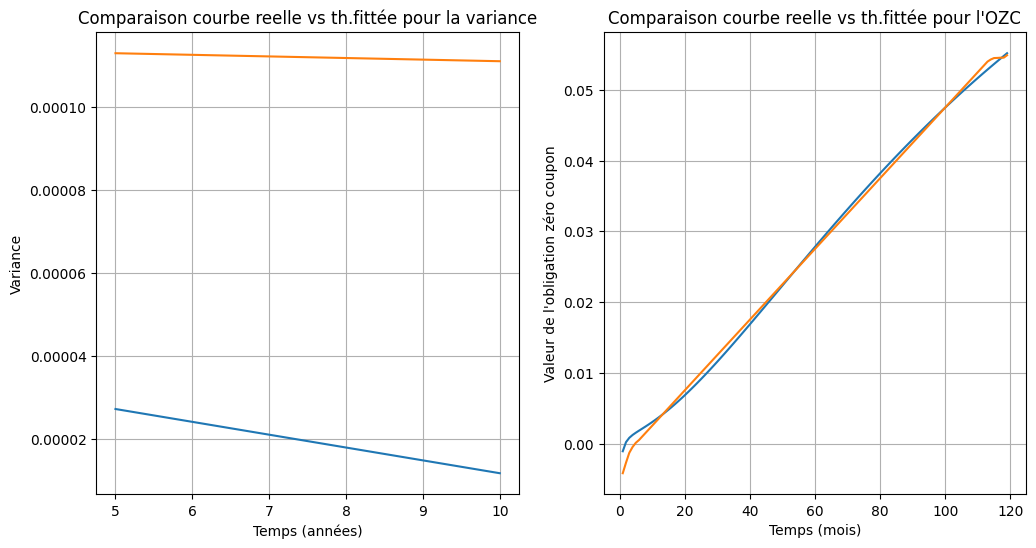

In [11]:
var_hist = []
var_th = []
for mat in mat_cible_var : 
    var_th.append(compute_th_var(param_calib_abs_g2pp, mat, delta_hist))
    var_hist.append(compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist))

init_zc_hist = []
init_zc_th = []
init_ZC =  donnees_marche['ZCR']
mat_init_ZCR = range(1,120)
for mat in mat_init_ZCR : 
    init_zc_th.append(compute_init_ZCR(param_calib_abs_g2pp, mat))
    init_zc_hist.append(init_ZC[mat])

plt.figure (figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot (mat_cible_var,var_th)
plt.plot (mat_cible_var,var_hist)
plt.xlabel("Temps (années)")
plt.ylabel("Variance")
plt.grid ()
plt.title("Comparaison courbe reelle vs th.fittée pour la variance")

plt.subplot(1,2,2)
plt.plot (mat_init_ZCR,init_zc_th)
plt.plot (mat_init_ZCR,init_zc_hist)
plt.xlabel("Temps (mois)")
plt.ylabel("Valeur de l'obligation zéro coupon")
plt.title("Comparaison courbe reelle vs th.fittée pour l'OZC")
plt.grid()
plt.show()

abs_errors_var = sum([
        # difference absolue de la variance
        (
            compute_th_var(param_calib_abs_g2pp, mat, delta_hist)
            - compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
        ) ** 2
        for mat in mat_cible_var
    ])

abs_errors_courbe_init = sum([
    # difference absolue de la dispersion
    (
        compute_init_ZCR(param_calib_abs_g2pp, mat)
        -  init_ZC[mat]
    ) ** 2
    for mat in mat_init_ZCR
    ])


In [12]:
# les paramètres optimaux
a_1_opt, a_2_opt, sigma_1_opt, sigma_2_opt, rho_opt = param_calib_abs_g2pp[:5]

# calculer les valeurs cibles induites par le modèle G2++
def compute_model_targets(param, mat_cible_var, mat_init_ZCR, delta_hist):
    targets = {}

    for mat in mat_cible_var:
        targets[f"Variance_{mat}"] = compute_th_var(param, mat, delta_hist)
    
    for mat in mat_init_ZCR:
        targets[f"ZC_{mat}"] = compute_init_ZCR(param, mat)
    


    return targets

# Calculer les valeurs cibles induites par le modèle G2++ avec les paramètres optimaux
model_targets = compute_model_targets(param_calib_abs_g2pp, mat_cible_var, mat_init_ZCR, delta_hist)

# Créer un DataFrame pour stocker les résultats
comparison_df = pd.DataFrame({
    "Target_Type": [],
    "Historical_Target": [],
    "Model_Target_Optimal_Parameters": [],
    "Relative_Error": []
})

# Ajoutez les valeurs cibles historiques et celles induites par le modèle aux DataFrame
comparison_list = []

# Pour les variances
for mat in mat_cible_var:
    historical_target = compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
    model_target = model_targets[f"Variance_{mat}"]
    relative_error = abs((historical_target - model_target) / historical_target) * 100
    
    comparison_list.append({
        "Target_Type": "Variance",
        "Historical_Target": historical_target,
        "Model_Target_Optimal_Parameters": model_target,
        "Relative_Error": relative_error
    })

# Pour les dispersions
for mat in mat_cible_var:
    
    historical_target = compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist)
    model_target = model_targets[f"ZC_{mat}"]
    print(model_target)
    relative_error = abs((historical_target - model_target) / historical_target) * 100
    
    comparison_list.append({
        "Target_Type": "ZC",
        "Historical_Target": historical_target,
        "Model_Target_Optimal_Parameters": model_target,
        "Relative_Error": relative_error
    })

# Création finale du DataFrame
comparison_df = pd.DataFrame(comparison_list)



# DataFrame
comparison_df

0.0015260855573821883
0.0030228856635087296


,Target_Type,Historical_Target,Model_Target_Optimal_Parameters,Relative_Error
0,Variance,0.000113,0.000027,75.876168
1,Variance,0.000111,0.000012,89.389112
2,ZC,0.003638,0.001526,58.051157
3,ZC,0.003191,0.003023,5.258528


In [13]:
mat_cible_var

[5, 10]

-> On remarque que en pratique que l'algorithme ne donne pas de résultats satisfaisant quand on compare les résultats obtenus par les données historiques car une erreur prépondére très largement par rapport à l'autre. 

##### Quel serait l'intérêt d'effectuer un calibrage se basant sur une fonction objective relative ?
L'utilisation d'une fonction objective relative peut offrir une perspective plus générale et robuste lors du calibrage de modèles financiers, en particulier dans des contextes où les valeurs cibles varient sur une large plage d'échelles ou lors de comparaisons entre différents actifs ou marchés.
Par exemple
- Comparaison entre différents actifs ou marchés 
- Robustesse par rapport aux changements d'échelle 
- Facilité d'interprétation
- Éviter les biais d'échelle

Le callibrage semble très insatisfaisant en vue des résulats obtenus 

-----------------------------------------------------------------------------------------------------------------------------

### Question 5 (2 pts)

En reprenant la définition de `compute_target_fun_abs_g2pp`, **définir** la fonction `compute_target_fun_rel_g2pp` qui permet de calculer l'erreur relative entre les cibles historiques et théoriques.

**Relancer** le calibrage en utilisant la fonction objective calculant l'erreur relative et **vérifier** qu'il est satisfaisant. Nous le conserverons dans la suite.

-----------------------------------------------------------------------------------------------------------------------------

In [14]:
# Target function

def compute_target_fun_rel_g2pp(param, mat_cible_var, mat_init_ZCR, init_ZC, hist_taux, delta_hist):
    # compute absolute error target function
    # param = [a_1, a_2, sigma_1, sigma_2, rho, x, y]
    # mat_cible_var is a list of maturities for volatility targets
    # mat_init_ZCR is the list of maturities composing the initial IR curve
    # delta_hist the historical data timestep
    # init_ZC is the initial ZCR curve

    a_1, a_2, sigma_1, sigma_2, rho, x, y = param

    are_constraints_verif = (a_1 > 0) and (a_2 > 0) and (sigma_1 > 0) and (sigma_2 > 0) and (abs(rho) <= 1)
    if not are_constraints_verif:
        return 1e10

    abs_errors_var = [
        # difference absolue de la variance
        (
            compute_th_var(param, mat, delta_hist)
            - compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
        ) ** 2
        for mat in mat_cible_var
    ]

    abs_errors_courbe_init = [
        # difference absolue de la dispersion
        (
            compute_init_ZCR(param, mat)
            -  init_ZC[mat]
        ) ** 2
        for mat in mat_init_ZCR
    ]
    var_histo = [
        # difference absolue de la variance
        compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
        for mat in mat_cible_var
    ]

    courbe_init_histo = [
        # difference absolue de la dispersion
        init_ZC[mat]
        for mat in mat_init_ZCR
    ]

    error = sum(abs_errors_var)/(sum(var_histo))+ sum(abs_errors_courbe_init)/(sum(courbe_init_histo))

    return error




In [15]:
# Optimization
mat_cible_var = [5, 10]

param_init=[0.2, 1, 0.05, 0.5, 0.5, 0.0, 0.0]
# (a_1, a_2, sigma_1, sigma_2, rho, x, y)
result_rel = minimize(
    fun=compute_target_fun_rel_g2pp,
    x0=param_init,
    args=(mat_cible_var, range(1,120), donnees_marche['ZCR'], hist_taux, delta_hist),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.00001, 'xatol': 0.000001, "adaptive":True}

)

param_calib_rel_g2pp = result_rel.x

In [16]:
result_rel.fun

7.806464421426221e-05

In [17]:
result_rel.x

array([ 0.02022541,  2.39404533,  0.00969534,  0.35202332, -0.09025681,
       -0.00910318,  0.01358227])

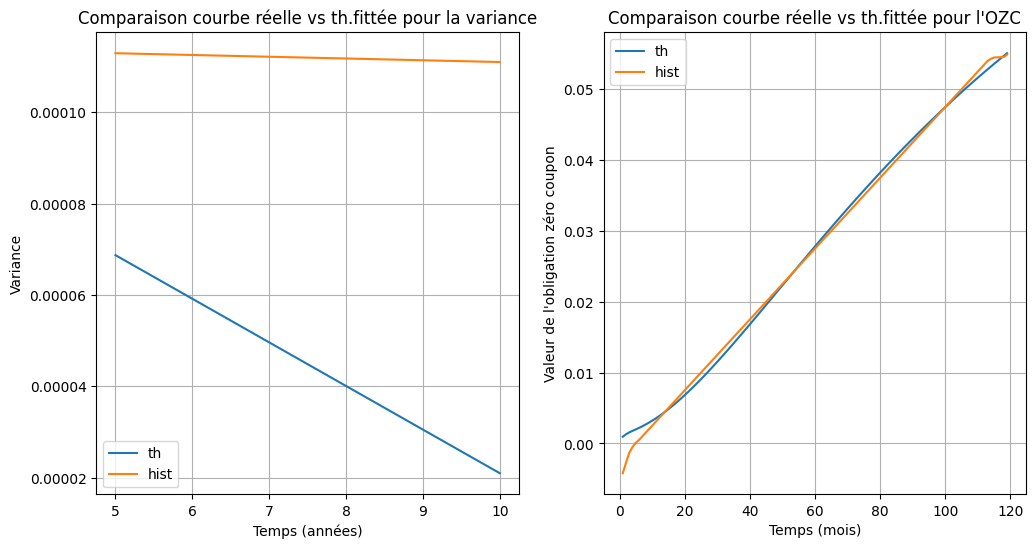

In [18]:
var_hist = []
var_th = []
for mat in mat_cible_var : 
    var_th.append(compute_th_var(param_calib_rel_g2pp, mat, delta_hist))
    var_hist.append(compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist))

init_zc_hist = []
init_zc_th = []
init_ZC =  donnees_marche['ZCR']
mat_init_ZCR = range(1,120)
for mat in mat_init_ZCR : 
    init_zc_th.append(compute_init_ZCR(param_calib_rel_g2pp, mat))
    init_zc_hist.append(init_ZC[mat])

plt.figure (figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot (mat_cible_var,var_th, label ="th")
plt.plot (mat_cible_var,var_hist,label ="hist")
plt.xlabel("Temps (années)")
plt.ylabel("Variance")
plt.grid ()
plt.title("Comparaison courbe réelle vs th.fittée pour la variance")
plt.legend ()
plt.subplot(1,2,2)
plt.plot (mat_init_ZCR,init_zc_th,label ="th")
plt.plot (mat_init_ZCR,init_zc_hist,label ="hist")
plt.xlabel("Temps (mois)")
plt.ylabel("Valeur de l'obligation zéro coupon")
plt.title("Comparaison courbe réelle vs th.fittée pour l'OZC")
plt.grid()
plt.legend()
plt.show()


On ne note pas d'amélioration significative du modèle 

In [19]:
# calculer les valeurs cibles induites par le modèle G2++
def compute_model_targets(param, mat_cible_var, mat_init_ZCR, delta_hist):
    targets = {}

    for mat in mat_cible_var:
        targets[f"Variance_{mat}"] = compute_th_var(param, mat, delta_hist)
    
    for mat in mat_init_ZCR:
        targets[f"ZC_{mat}"] = compute_init_ZCR(param, mat)
    


    return targets

# Calculer les valeurs cibles induites par le modèle G2++ avec les paramètres optimaux
model_targets = compute_model_targets(result_rel.x, mat_cible_var, mat_init_ZCR, delta_hist)

# Créer un DataFrame pour stocker les résultats
comparison_df = pd.DataFrame({
    "Target_Type": [],
    "Historical_Target": [],
    "Model_Target_Optimal_Parameters": [],
    "Relative_Error": []
})

# Ajoutez les valeurs cibles historiques et celles induites par le modèle aux DataFrame
comparison_list = []

# Pour les variances
for mat in mat_cible_var:
    historical_target = compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
    model_target = model_targets[f"Variance_{mat}"]
    relative_error = abs((historical_target - model_target) / historical_target) * 100
    
    comparison_list.append({
        "Target_Type": "Variance",
        "Historical_Target": historical_target,
        "Model_Target_Optimal_Parameters": model_target,
        "Relative_Error": relative_error
    })

# Pour les dispersions
for mat in mat_cible_var:
    
    historical_target = compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist)
    model_target = model_targets[f"ZC_{mat}"]
    print(model_target)
    relative_error = abs((historical_target - model_target) / historical_target) * 100
    
    comparison_list.append({
        "Target_Type": "ZC",
        "Historical_Target": historical_target,
        "Model_Target_Optimal_Parameters": model_target,
        "Relative_Error": relative_error
    })

# Création finale du DataFrame
comparison_df = pd.DataFrame(comparison_list)



# DataFrame
comparison_df

0.0019891870443960458
0.0032089507100688834


,Target_Type,Historical_Target,Model_Target_Optimal_Parameters,Relative_Error
0,Variance,0.000113,0.000069,39.145057
1,Variance,0.000111,0.000021,81.090257
2,ZC,0.003638,0.001989,45.321483
3,ZC,0.003191,0.003209,0.573011


On a une amélioration très significative des erreurs relatives maison reste tout de même loin de la barre des 5% qui pourrait nous conforter dans l'hypothèse que le modèle est bon

---

Les paramètres $\Theta_r$ étant calibrés (et égaux à $\Theta_r^*$), restent à calibrer les paramètres primes de risque $\Gamma=(\gamma_1, \gamma_2)$. Ils peuvent être estimés en répliquant le niveau moyen asymptotique (à $t \rightarrow +\infty$) des taux Zéro-Coupon. Pour calibrer ces PDR, **nous utiliserons les taux 5A et 10A**.

Sur l'historique, nous pouvons estimer le niveau moyen cible à réproduire lors du calibrage par l'estimateur suivant :

$$
    \hat{M}_R(\tau) = \frac{1}{N} \sum_{k=1}^{N}  R^{\text{Mkt}}(t_k, t_k+\tau).
$$

-----------------------------------------------------------------------------------------------------------------------------

### Question 6 (1 pt)

Donner l'expression du niveau théorique asymptotique des niveaux (et non pas de leurs incréments) de taux : 
$$
    M_R(\tau, \Gamma) =: \lim_{t \rightarrow \infty} \mathbb{E} \big[ R^{\text{Mod}}(t,t+\tau) \big].
$$

-----------------------------------------------------------------------------------------------------------------------------

Les facteurs de taux $ x_t $ et $ y_t $ suivent des dynamiques de type Ornstein–Uhlenbeck, intégrant des primes de risque $ \gamma_1 $ et $ \gamma_2 $ :

$$
\begin{aligned}
dx_t &= -a_1\,x_t\, dt + \sigma_1\,\gamma_1\, dt + \sigma_1\, dW^1_t \\
dy_t &= -a_2\,y_t\, dt + \sigma_2\,\gamma_2\, dt + \sigma_2\, dW^2_t
\end{aligned}
$$

Ces processus convergent vers des régimes stationnaires dont les espérances sont :

$$
\lim_{t \to \infty} \mathbb{E}[x_t] = \frac{\sigma_1\,\gamma_1}{a_1}, \quad 
\lim_{t \to \infty} \mathbb{E}[y_t] = \frac{\sigma_2\,\gamma_2}{a_2}
$$

Le taux zéro-coupon modélisé à l’instant $ t $ pour une maturité $ \tau $ s’écrit :

$$
R^{\text{Mod}}(t, t + \tau) = \frac{1}{\tau} \left( B(\tau; a_1)\,x_t + B(\tau; a_2)\,y_t + \frac{1}{2} A(\tau; a_1, a_2, \sigma_1, \sigma_2, \rho) \right)
$$

En prenant la limite en $ t \to \infty $, on remplace $ x_t $ et $ y_t $ par leurs moyennes stationnaires, ce qui donne :

$$
\lim_{t \to \infty} \mathbb{E}\left[R^{\text{Mod}}(t, t + \tau)\right] = \frac{1}{\tau} \left( 
B(\tau; a_1) \cdot \frac{\sigma_1\,\gamma_1}{a_1} + 
B(\tau; a_2) \cdot \frac{\sigma_2\,\gamma_2}{a_2} + 
\frac{1}{2} A(\tau; a_1, a_2, \sigma_1, \sigma_2, \rho)
\right)
$$

Finalement, on obtient l’expression recherchée :

$$
\boxed{
M_R(\tau, \Gamma) = \frac{1}{\tau} \left( 
B(\tau; a_1) \cdot \frac{\sigma_1\,\gamma_1}{a_1} + 
B(\tau; a_2) \cdot \frac{\sigma_2\,\gamma_2}{a_2} + 
\frac{1}{2} A(\tau; a_1, a_2, \sigma_1, \sigma_2, \rho)
\right)
}
$$

avec $ \Gamma = (\gamma_1, \gamma_2) $.


Les primes de risque $\Gamma = \{\gamma_1, \gamma_2 \}$ sont alors calibrées comme des solutions du problème d'optimisation suivant :

$$
\Gamma^* = \text{argmin}_{\Gamma} \sum_{i=1}^{2} \left(M_R(\tau'_i, \Gamma) - \hat{M}_R(\tau'_i) \right)^2
$$

où $\tau'_1=5A$ et $\tau'_2=10A$.

-----------------------------------------------------------------------------------------------------------------------------

### Question 7 (2 pts)

À partir des éléments théoriques ci-dessus, et en s'inspirant des **questions 4 et 5**, **définir** les fonctions suivantes :
* `compute_th_mean(param, gamma_1, gamma_2, mat)`, qui calcule le niveau moyen théorique des taux de maturité `mat`.
* `compute_hist_mean(hist_taux)`, qui calcule le niveau moyen historique d'un vecteur de taux `hist_taux`
* `compute_target_fun_risk_premia_g2pp(gammas, param_calib_g2pp, mat_cible_mean)`, qui calcule la fonction d'erreur du programme d'optimisation défini ci-dessus en appelant les fonctions précédentes ; avec:
    * `gammas` une liste contenant deux valeurs: `gamma_1` et `gamma_2`.
    * `mat_cible_mean` une liste contenant les maturités cibles pour la réplication du niveau moyen.

Il est conseillé d'utiliser les fonctions auxiliaires suivantes.

-----------------------------------------------------------------------------------------------------------------------------

In [20]:
# -----------------------------------------
# Fonctions Auxiliaires calcul theorique G2++
# -----------------------------------------

def compute_B(t, a):
    return (1-np.exp(-a*t))/a

def compute_A(t, param):
    
    a_1, a_2, sigma_1, sigma_2, rho = param

    R_1 = sigma_1**2/a_1**2 * (
        t + 2 / a_1 * np.exp(-a_1 * t) - 1 / (2 * a_1) * np.exp(-2 * a_1 * t)
        - 3 / (2 * a_1)
    )

    R_2 = sigma_2**2/a_2**2 * (
        t + 2 / a_2 * np.exp(-a_2 * t) - 1 / (2 * a_2) * np.exp(-2 * a_2 * t)
        - 3 / (2 * a_2)
    )

    R_3 = 2 * rho * sigma_1 * sigma_2 / (a_1 * a_2) * (
        t - compute_B(t, a_1) - compute_B(t, a_2) + compute_B(t, a_1 + a_2)
    )

    result = R_1 + R_2 + R_3

    return result

In [21]:
def compute_th_mean(param, gamma_1, gamma_2, mat):
    a_1, a_2, sigma_1, sigma_2, rho, x, y = param
    mean_th = (compute_B(mat, a_1)*(sigma_1*gamma_1/a_1)+compute_B(mat, a_2)*(sigma_2*gamma_2/a_2)+0.5*compute_A(mat, [a_1, a_2, sigma_1, sigma_2, rho]))/mat
    return mean_th

def compute_hist_mean(hist_taux):
    return np.mean(hist_taux)

def compute_target_fun_risk_premia_g2pp(gammas, param_calib_g2pp, mat_cible_mean, hist_taux):
    gamma_1, gamma_2 = gammas
    error = 0.0
    for mat in mat_cible_mean:
        th_mean = compute_th_mean(param_calib_g2pp, gamma_1, gamma_2, mat)        
        hist_mean = compute_hist_mean(get_hist_taux_m(mat, hist_taux))
        error += (th_mean -hist_mean)**2
    return error

Le programme d'optimisation suivant est lancé pour calibrer les primes de risque.

In [22]:
param_calib_rel_g2pp

array([ 0.02022541,  2.39404533,  0.00969534,  0.35202332, -0.09025681,
       -0.00910318,  0.01358227])

In [23]:
# Optimisation

mat_cible_mean = [5, 10]

gammas_init = [0.05, -0.025]

result_rel_gammas = minimize(
    fun=compute_target_fun_risk_premia_g2pp,
    x0=gammas_init,
    args=(param_calib_rel_g2pp, mat_cible_mean, hist_taux),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.0001, 'xatol': 0.0001, "adaptive":True}
)

gamma_calib_g2pp = result_rel_gammas.x
gamma_1, gamma_2 = gamma_calib_g2pp

In [24]:
result_rel_gammas.nit # On vérifie que l'algorithme ne s'arrête pas prématurément

48

In [25]:
result_rel_gammas.fun

6.226344871618734e-14

## <ins>Calibrage modèle action</ins>

Nous allons à présent calibrer le modèle action. Il s'agit de rechercher les paramètres **positifs** $\Theta_s = (\mu, \sigma)$ qui permettront au mieux de reproduire à la simulation des quantités distributionnelles observées sur l'historique de données (dans le cas présent, la tendance et la variance des log rendements). 



-----------------------------------------------------------------------------------------------------------------------------

### Question 8 (1 pt)

Le calibrage va s'effectuer à partir des moments des log rendements de l'action. Dans un premier temps, **préparer** les données et **calculer** les cibles distributionnelles empiriques de moyenne et variance sur l'historique de données, notées respectivement $\widehat{m}$ et $\widehat{v}$.



-----------------------------------------------------------------------------------------------------------------------------


In [26]:
# Completer
donnees_histo['Action']
# calcul des log rendements 
donnees_histo ['log_rendement'] = np.log(donnees_histo['Action']).diff()
m_bar = np.mean(donnees_histo ['log_rendement'])
v_bar = np.var(donnees_histo ['log_rendement'])

In [27]:
m_bar, v_bar

(0.0045659109033243115, 0.0032425939077956184)

-----------------------------------------------------------------------------------------------------------------------------


#### Question 9 (1 pt)

Le calibrage du modèle va être effectué à l'aide de la méthode des moments. Pour cela, l'expression théorique de l'espérance des log rendements de l'action est nécéssaire. Donner les expressions de : $\newline$
$\mathbb{E}\left[\ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] $ et 
$\mathbb{V}\text{ar}\left[\ln\left(\frac{S_{t+\delta}}{S_t}\right)\right]$.


En déduire en les valeurs calibrées des paramètres $\mu^*$ et $\sigma^*$.


-----------------------------------------------------------------------------------------------------------------------------

Dans la suite, nous conservons le calibrage de la question 8.

On considère le modèle de Black-Scholes :

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dB_t
$$

En appliquant la formule d’Itô à $ \ln(S_t) $, on obtient :

$$
d\ln(S_t) = \left(\mu - \frac{1}{2} \sigma^2\right) dt + \sigma dB_t
$$

On peut donc intégrer cette expression sur l’intervalle $ [t, t+\delta] $:

$$
\ln\left(\frac{S_{t+\delta}}{S_t}\right) = \left(\mu - \frac{1}{2} \sigma^2\right) \delta + \sigma \left( B_{t+\delta} - B_t \right)
$$

Puisque $ B_{t+\delta} - B_t \sim \mathcal{N}(0, \delta) $ cela implique que :

---

#### Espérance :

$$
\mathbb{E}\left[\ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] = \left(\mu - \frac{1}{2} \sigma^2\right) \delta
$$

---

#### Variance :

$$
\text{Var}\left[\ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] = \sigma^2 \delta
$$

---

### Calibrage des paramètres $ \mu^* $ et $ \sigma^* $

À partir d’un échantillon de données empiriques (par exemple les log-rendements observés), on peut estimer :

- $ \bar{m} = $ la moyenne empirique des log-rendements sur une période $\delta $
- $ s^2 = $ la variance empirique de ces log-rendements

En identifiant les moments empiriques et théoriques, on obtient :

$$
\sigma^{*2} = \frac{s^2}{\delta} =\frac{V}{\delta} , \quad \mu^* = \frac{\bar{m}}{\delta} + \frac{1}{2} \sigma^{*2}
$$

Ces formules permettent donc de calibrer les paramètres $ \mu $ et $ \sigma $ du modèle de Black-Scholes à partir des données observées.


In [28]:
# Completer
sigma_star = np.sqrt(v_bar/delta_hist)
m_star = (m_bar/delta_hist)+(1/2)*sigma_star**2

## <ins>Calibrage des corrélations</ins>

Maintenant que les modèles ont été calibrés individuellement, il s'agit de déterminer les coefficients de corrélations entre les mouvements Browniens $B$ et $W^1$ / $W^2$. Notons $\rho_1$ et $\rho_2$ les coefficients de corrélation respectifs qui sont tels que 
$$
\mathbb{E}[B_t W^1_t] = \rho_1 t, \\
\mathbb{E}[B_t W^2_t] = \rho_2 t.
$$

Rappelons que la corrélation $\rho$ spécifiant la loi jointe de $(W^1, W^2)$ a déjà été calibré auparavant. 

En notant les incréments de taux de temps à maturité fixée $\tau$ sur un intervalle de longueur $\delta_{\text{histo}}$ par $\Delta R^{\text{Mod}}(\delta_{\text{histo}},\tau) = R^{\text{Mod}}(t+\delta_{\text{histo}},t+\delta_{\text{histo}}+\tau) - R^{\text{Mod}}(t+,t+\tau)$ et par $\Delta' S_t = \ln(S_{t+\delta_{\text{histo}}}/S_t)$ le log-incrément d'indice action, on peut montrer que la corrélation entre ces quantités induites par les modèles sélectionnés s'écrit : 
$$
\rho^{\text{Mod}}\big(\Delta R^{\text{Mod}}(\delta_{\text{histo}},\tau), \Delta' S_t \big)=\sqrt{\frac{1-e^{-2a_1\delta_{\text{histo}}}}{2a_1}}\frac{\sigma_1(1-e^{-a_1\tau})}{\tau a_1 \Sigma_{\Delta R}(\delta_{hist}, \tau; \Theta_r)} \rho_1 + \sqrt{\frac{1-e^{-2a_2\delta_{\text{histo}}}}{2a_2}} \frac{\sigma_2(1-e^{-a_2\tau})}{\tau a_2 \Sigma_{\Delta R}(\delta_{hist}, \tau; \Theta_r)} \rho_2, 
$$

où 
$$
\Sigma_{\Delta R}(\delta_{\text{histo}}, \tau; \Theta_r)^2 = \sum_{i=1}^{2} \left(\frac{{1}-{e}^{-{a}_{i}{\tau}}}{{a}_{i}{\tau}}\right)^{2}\frac{{\sigma}_{i}^{2}}{{a}_{i}}\left({1}-{e}^{-{a}_{i}{\delta_{\text{histo}}}}\right)
+ 2 \frac{(1-e^{-a_1 \tau})(1-e^{-a_2 \tau})}{a_1 a_2 \tau^2} \frac{ \rho \sigma_1 \sigma_2}{a_1 + a_2}  (2 - e^{-a_1 \delta_{\text{histo}} } - e^{-a_2 \delta_{\text{histo}} }).
$$

Pour déterminer $\rho_1, \rho_2$, nous allons évaluer cette équation en deux (temps à) maturités de taux fixées : $\tau_1 = 1$ et $\tau_2 = 10$. Nous allons donc mesurer sur historique deux corrélations cibles $\rho_1^{\text{Cible}}$ et $\rho_2^{\text{Cible}}$, mesurées sur des séries de *log-rendements* action et *d'incréments* de taux de maturités 1 an et 10 ans. Nous pourrons alors résoudre le système d'équation suivant : 
$$
\sqrt{\frac{1-e^{-2a_1\delta_{\text{histo}}}}{2a_1}}\frac{\sigma_1(1-e^{-a_1\tau_1})}{a_1 \tau_1 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_1; \Theta_r)} \rho_1 + \sqrt{\frac{1-e^{-2a_2\delta_{\text{histo}}}}{2a_2}} \frac{\sigma_2(1-e^{-a_2\tau})}{a_2 \tau_1 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_1; \Theta_r)} \rho_2 = \rho_1^{\text{Cible}},
$$

$$
\sqrt{\frac{1-e^{-2a_1\delta_{\text{histo}}}}{2a_1}}\frac{\sigma_1(1-e^{-a_1\tau_2})}{a_1 \tau_2 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_2; \Theta_r)} \rho_1 + \sqrt{\frac{1-e^{-2a_2\delta_{\text{histo}}}}{2a_2}} \frac{\sigma_2(1-e^{-a_2\tau_2})}{a_2 \tau_2 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_2; \Theta_r)} \rho_2 = \rho_2^{\text{Cible}}.
$$

### On doit recalculer les gammas parce que les maturités à taux fixés sont à 1 et 10 ans et plus 5 et 10 

---

In [29]:
hist_taux

,Taux 1A,Taux 5A,Taux 10A
0,0.047884,0.052215,0.053417
1,0.049847,0.051531,0.055923
2,0.049682,0.051998,0.053919
3,0.050510,0.052339,0.053900
4,0.051925,0.055890,0.060459
...,...,...,...
297,0.055110,0.040611,0.038938
298,0.058254,0.040951,0.040886
299,0.055703,0.045235,0.045479
300,0.056149,0.049739,0.046705


In [30]:
mat_cible_mean = [1, 10]


gammas_init = [0.05, -0.025]
param_init=[0.2, 1, 0.05, 0.5, 0.5, 0.0, 0.0]

# (a_1, a_2, sigma_1, sigma_2, rho, x, y)
result_rel = minimize(
    fun=compute_target_fun_rel_g2pp,
    x0=param_init,
    args=(mat_cible_var, range(1,120), donnees_marche['ZCR'], hist_taux, delta_hist),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.00001, 'xatol': 0.000001, "adaptive":True}

)
result_rel_gammas = minimize(
    fun=compute_target_fun_risk_premia_g2pp,
    x0=gammas_init,
    args=(param_calib_rel_g2pp, mat_cible_mean, hist_taux),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.0001, 'xatol': 0.0001, "adaptive":True}
)

gamma_calib_g2pp = result_rel_gammas.x
gamma_1, gamma_2 = gamma_calib_g2pp

gamma_calib_g2pp = result_rel_gammas.x
gamma_1, gamma_2 = gamma_calib_g2pp
result_rel_gammas.nit # On vérifie que l'algorithme ne s'arrête pas prématurément
result_rel_gammas.fun

1.6363069773185848e-12

In [31]:
param_calib_rel_g2pp 

array([ 0.02022541,  2.39404533,  0.00969534,  0.35202332, -0.09025681,
       -0.00910318,  0.01358227])

In [32]:
# -----------------------------------------
# Fonctions auxiliaires estimation des correlations
# -----------------------------------------

# Une matrice est-elle semi-definie positive ?
def Is_PSD(matrice):
    valeurs_propres = np.linalg.eigvals(matrice)
    return all(valeur >= 0 for valeur in valeurs_propres)

# On transforme une matrice quelconque en matrice PSD
def Into_PSD(matrice):
    val_propres, vec_propres = np.linalg.eigh(matrice)
    val_propres[val_propres < 0] = 0  # Mettre à zéro les valeurs propres négatives
    matrice_psd = vec_propres @ np.diag(val_propres) @ vec_propres.T
    return matrice_psd

-----------------------------------------------------------------------------------------------------------------------------

### Question 10 (1 pt)

**Estimer** grâce aux séries historiques les corrélations historiques cibles. 

-----------------------------------------------------------------------------------------------------------------------------

In [33]:
# Completer

# Calculer les différences de taux d'intérêt pour les maturités de 1 an, 5 ans et 10 ans
donnees_histo['Diff_Taux_1A'] = donnees_histo['Taux 1A'].diff(periods=1)
donnees_histo['Diff_Taux_5A'] = donnees_histo['Taux 5A'].diff(periods=1)
donnees_histo['Diff_Taux_10A'] = donnees_histo['Taux 10A'].diff(periods=1)

# corrélation cible pour une maturité de 1 an
rho1_cible = donnees_histo ['log_rendement'].corr(donnees_histo['Diff_Taux_1A'])

# corrélation cible pour une maturité de 10 ans
rho2_cible = donnees_histo ['log_rendement'].corr(donnees_histo['Diff_Taux_10A'])

print("Corrélation cible pour une maturité de 1 an :", rho1_cible)
print("Corrélation cible pour une maturité de 10 ans :", rho2_cible)


Corrélation cible pour une maturité de 1 an : 0.110273834272543
Corrélation cible pour une maturité de 10 ans : 0.1195624703290675


-----------------------------------------------------------------------------------------------------------------------------

### Question 11 (2 pts)

**Implémenter** la résolution du système d'équations précédent pour déterminer les coefficients de corrélations entre Browniens.

-----------------------------------------------------------------------------------------------------------------------------

In [34]:
def compute_th_variance_delta_R(param, tau, delta_hist):
    a1, a2, sigma1, sigma2, rho, x, y = param
    term1 = ((1 - np.exp(-a1 * tau)) / (a1 * tau))**2 * (sigma1**2 / a1) * (1 - np.exp(-a1 * delta_hist))
    term2 = ((1 - np.exp(-a2 * tau)) / (a2 * tau))**2 * (sigma2**2 / a2) * (1 - np.exp(-a2 * delta_hist))
    term3 = 2 * ((1 - np.exp(-a1 * tau)) * (1 - np.exp(-a2 * tau)) / (a1 * a2 * tau**2)) * (rho * sigma1 * sigma2 / (a1 + a2)) * (2 - np.exp(-a1 * delta_hist) - np.exp(-a2 * delta_hist))
    return term1 + term2 + term3

def compute_coeff_A(param, tau, delta_hist):
    a1, a2, sigma1, sigma2, rho, x, y = param
    Sigma = np.sqrt(compute_th_variance_delta_R(param, tau, delta_hist))
    A_tau = np.sqrt((1 - np.exp(-2 * a1 * delta_hist)) / (2 * a1)) * (sigma1 * (1 - np.exp(-a1 * tau))) / (a1 * tau * Sigma)
    return A_tau

def compute_coeff_B(param, tau, delta_hist):
    a1, a2, sigma1, sigma2, rho, x, y = param
    Sigma = np.sqrt(compute_th_variance_delta_R(param, tau, delta_hist))
    B_tau = np.sqrt((1 - np.exp(-2 * a2 * delta_hist)) / (2 * a2)) * (sigma2 * (1 - np.exp(-a2 * tau))) / (a2 * tau * Sigma)
    return B_tau

def solve_rho_system(param, delta_hist, tau1, tau2, rho1_cible, rho2_cible):
    A1 = compute_coeff_A(param, tau1, delta_hist)
    B1 = compute_coeff_B(param, tau1, delta_hist)
    A2 = compute_coeff_A(param, tau2, delta_hist)
    B2 = compute_coeff_B(param, tau2, delta_hist)
    M = np.array([[A1, B1],
                  [A2, B2]])
    rhs = np.array([rho1_cible, rho2_cible])
    rho_sol = np.linalg.solve(M, rhs)  
    return rho_sol

# Exemple
tau1 = 1
tau2 = 10
rho1_cible = 0.110273834272543
rho2_cible = 0.11956247032906737

rho_solution = solve_rho_system(param_calib_rel_g2pp, delta_hist, tau1, tau2, rho1_cible, rho2_cible)
rho_1, rho_2 = rho_solution
print("rho_1 =", rho_1)
print("rho_2 =", rho_2)

rho_1 = 0.046559769907076394
rho_2 = 0.11152369464812194


La matrice de corrélation en entrée du GSE associée au vecteur de Brownien $(W^1, W^2, B)$ est donc la suivante : 
$$
\begin{bmatrix} 
1 & \rho & \rho_1 \\ 
\rho & 1 & \rho_2 \\ 
\rho_1 & \rho_2 & 1 
\end{bmatrix},
$$
où $\rho$ a été déterminé en question 5 et $\rho_1$ et $\rho_2$ ont été déterminés en question 10.

-----------------------------------------------------------------------------------------------------------------------------

### Question 12 (1 pt)
**S'agit-t-il d'une matrice semi-définie positive** ? Si oui, la **conserver** pour la suite. Sinon, la **transformer** en matrice semi-définie positive et **conserver** cette dernière.

**Renseigner** la matrice finale dans une variable nommée `correl_brownians_psd`.

-----------------------------------------------------------------------------------------------------------------------------


In [35]:
# Completer
rho = param_calib_rel_g2pp [4]
matrice =  np.array([[1, rho, rho_1],[rho,1, rho_2],[rho_1,rho_2,1]])
if Is_PSD(matrice) : 
    matrice_psd = matrice 
    print (matrice_psd)
    print ("La matrice d'origine était bien définie positive ")
else : 
    matrice_psd = Into_PSD(matrice)
    print (matrice_psd)
    print ("La matrice d'origine n'était pas définie positive ")

[[ 1.         -0.09025681  0.04655977]
 [-0.09025681  1.          0.11152369]
 [ 0.04655977  0.11152369  1.        ]]
La matrice d'origine était bien définie positive 


## <ins>Génération des Browniens</ins>

Nous allons à présent passer à la simulation des modèles. Avant cela,il nous faut simuler des incréments de mouvements Browniens en quantité suffisante. 

Supposons qu'il nous faille simuler des trajectoires de taux courts et d'indice action jusqu'à un horizon $h=20$ ans. Dans un premier temps, nous souhaitons simuler les quantités à pas annuels : $\delta_{\text{simu}}=1$. Pour simuler un trajectoire de taux court, nous avons besoin de deux trajectoires de mouvements Browniens ($W^1$ et $W^2$) tandis qu'une seule suffit pour simuler l'indice action $B$ soit un total de trois facteurs stochastiques à simuler. Enfin, nous souhaitons réaliser un nombre de $N_S=10000$ simulations. Tous les taux de maturités parmis $\{1, \dots, M\}$, $M \in \mathbb{N}$ seront simulés. 

In [36]:
#Paramètres globaux de la simulation 
h = 20
n_s = 10000
n_f = 3
p_y = 1
delta_simu = int(1/p_y)
M = 30

-----------------------------------------------------------------------------------------------------------------------------

### Question 13 (0.5 pt)

**Compléter** le code ci-dessous de sorte à obtenir dans `brownians` des trajectoires de mouvements Browniens corrélés selon la matrice `matrice_psd`. **Calculer** la corrélation empirique de la dernière valeur de `brownian_increments[:,i,:]`, et **vérifier** qu'elle est proche de `correl_brownians_psd`.

-----------------------------------------------------------------------------------------------------------------------------

In [37]:
brownians = np.zeros((n_s, h*delta_simu+1, n_f))
brownian_increments = np.zeros_like(brownians)

for i in range(1,(h*delta_simu)+1):
    increments = np.random.normal(0, 1, size=(n_s, 3)) * np.sqrt(delta_simu)
    brownian_increments[:,i,:] =  increments @ np.linalg.cholesky(matrice_psd).T
    brownians[:,i,:] = brownians[:,i-1,:] + brownian_increments[:,i,:] 
    
    
correlation_empirical = np.corrcoef(brownian_increments[:, -1, :], rowvar=False)



### On fait une vérification des résultats 

In [38]:

print("Corrélation empirique de la dernière valeur de brownian_increments :")
print(correlation_empirical)
print("\nCorrélation attendue selon matrice_psd :")
print(matrice_psd)

Corrélation empirique de la dernière valeur de brownian_increments :
[[ 1.         -0.08049791  0.04815044]
 [-0.08049791  1.          0.11203084]
 [ 0.04815044  0.11203084  1.        ]]

Corrélation attendue selon matrice_psd :
[[ 1.         -0.09025681  0.04655977]
 [-0.09025681  1.          0.11152369]
 [ 0.04655977  0.11152369  1.        ]]


Les valeurs calculées étant proches de 0 et le nombre de point n'étant pas infini on observe un léger écart de l'ordre de $ 10^{-3} $ mais on considérera cela satisfaisant pour les futurs similations. 

-----------------------------------------------------------------------------------------------------------------------------

### Question 14 (1 pt)

**Tracer** quelques trajectoires de mouvements Browniens ainsi simulés. **Vérifier** empiriquement qu'il s'agit bien de mouvement Browniens (en étudiant par exemple moyennes, variances, corrélations au cours du temps). 

-----------------------------------------------------------------------------------------------------------------------------

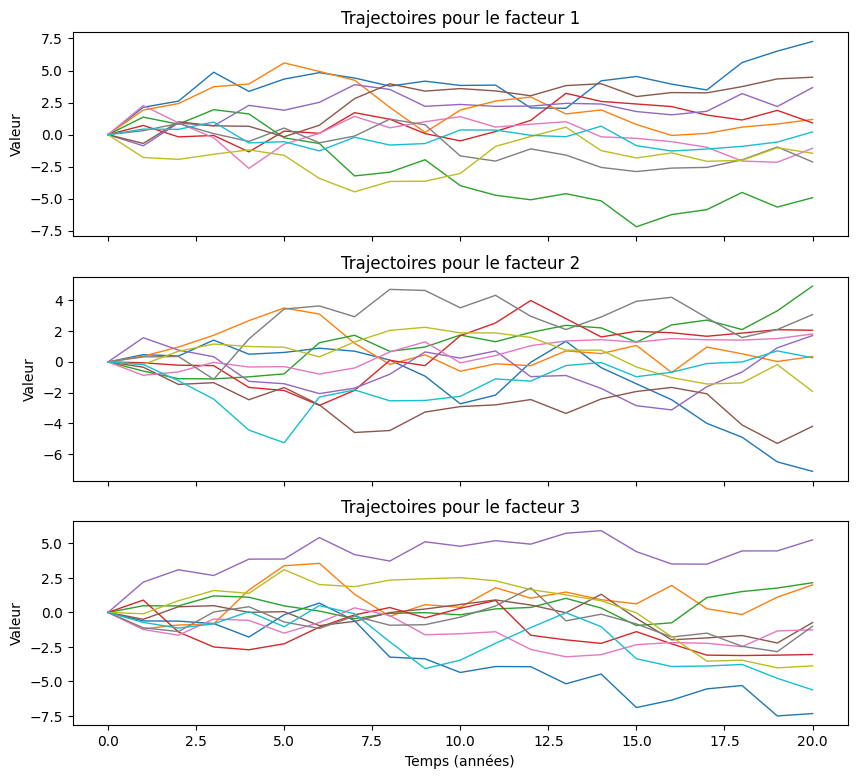

In [39]:
n_trajs_to_plot = 10
time_grid = np.linspace(0, h, h * delta_simu + 1)

fig, axs = plt.subplots(n_f, 1, figsize=(10, 3*n_f), sharex=True)
for j in range(n_f):
    for i in range(n_trajs_to_plot):
        axs[j].plot(time_grid, brownians[i, :, j], lw=1)
    axs[j].set_title(f"Trajectoires pour le facteur {j+1}")
    axs[j].set_ylabel("Valeur")
axs[-1].set_xlabel("Temps (années)")
plt.show()

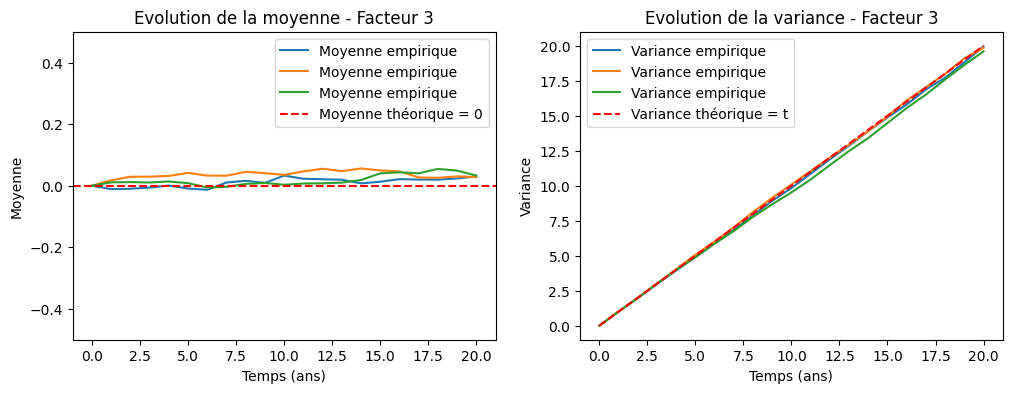

Matrice de corrélation empirique des incréments à l'instant final :
[[ 1.         -0.08049791  0.04815044]
 [-0.08049791  1.          0.11203084]
 [ 0.04815044  0.11203084  1.        ]]

Matrice de corrélation cible (correl_brownians_psd) :
[[ 1.         -0.09025681  0.04655977]
 [-0.09025681  1.          0.11152369]
 [ 0.04655977  0.11152369  1.        ]]


In [40]:
empirical_means = np.mean(brownians, axis=0)
empirical_vars  = np.var(brownians, axis=0, ddof=1)

fig, axs = plt.subplots(1 , 2, figsize=(12, 4))
for j in range(n_f):
    axs[0].plot(time_grid, empirical_means[:, j], label="Moyenne empirique")
    axs[0].set_title(f"Evolution de la moyenne - Facteur {j+1}")
    axs[0].set_xlabel("Temps (ans)")
    axs[0].set_ylabel("Moyenne")
    axs[0].set_ylim([-0.5,0.5])
    
    axs[1].plot(time_grid, empirical_vars[:, j], label="Variance empirique")
    axs[1].set_title(f"Evolution de la variance - Facteur {j+1}")
    axs[1].set_xlabel("Temps (ans)")
    axs[1].set_ylabel("Variance")
    
axs[0].axhline(0, color='red', linestyle='--', label="Moyenne théorique = 0")
axs[1].plot(time_grid, time_grid, 'r--', label="Variance théorique = t")
axs[0].legend()
axs[1].legend()
plt.show()

empirical_corr_final = np.corrcoef(brownian_increments[:, -1, :], rowvar=False)
print("Matrice de corrélation empirique des incréments à l'instant final :")
print(empirical_corr_final)
print("\nMatrice de corrélation cible (correl_brownians_psd) :")
print(matrice_psd)

On a bien des mouvements browniens, en effet : 
- Les moyennes restent proches de 0.
- Les variances croissent linéairement avec le temps.
- Les corrélations entre les facteurs (à chaque instant) restent proches des valeurs de matrice_psd.


## <ins>Simulation</ins>

Nous allons à présent utiliser les mouvements Browniens générés pour simuler des trajectoires de taux et d'actions. 
 
1) <ins> Simulation des taux </ins>

D'après la question 1, nous pouvons écrire le schéma récursif suivant permettant de simuler des trajectoires de taux court : entre deux dates de simulations $t_{k-1}$ et $t_k=t_{k-1}+\delta_{\text{simu}}$, nous avons 
$$
x\left(t_k\right)=x\left(t_{k-1}\right)e^{-a_1 \delta_{\text{simu}} }+\sigma_1 e^{-a_1t_k}\left(\int_{t_{k-1\ }}^{t_k}{e^{a_1u}dW^1_u}+\int_{t_{k-1\ }}^{t_k}{e^{a_1u}\gamma_1(u)du}\right) = x\left(t_{k-1}\right)e^{-a_1 \delta_{\text{simu}} }+\sigma_1 \gamma_1 e^{-a_1t_k} \frac{e^{a_1 t_{k+1}} - e^{a_1 t_k}}{a}+\sigma_1 e^{-a_1t_k}\sqrt{\frac{e^{2a_1t_k}-e^{2a_1t_{k-1}}}{2a_1}} G^{(1)}_{k}, 
$$

$$
y\left(t_k\right)=y\left(t_{k-1}\right)e^{-a_2 \delta_{\text{simu}} }+\sigma_2 e^{-a_2t_k}\left(\int_{t_{k-1}}^{t}{e^{a_2u}dW^2_u}+\int_{t_{k-1\ }}^{t_k}{e^{a_2u}\gamma_2(u)du}\right)\  = \ y\left(t_{k-1}\right)e^{-a_2 \delta_{\text{simu}} }+\sigma_2 \gamma_2  e^{-a_2t_k} \frac{e^{a_2 t_{k+1}} - e^{a_2 t_k}}{a} +\sigma_2 e^{-a_2t_k}\sqrt{\frac{e^{2a_2t_k}-e^{2a_2t_{k-1}}}{2a_2}}G^{(2)}_{k},
$$

où $(G^{(1)}_{k}, G^{(2)}_{k})_{k=1, \dots, h \times \delta_{simu} }$ est une suite i.i.d de vecteurs gaussiens centrés et de matrice de corrélation :
$$
\begin{bmatrix} 
1 & \rho  \\ 
\rho & 1
\end{bmatrix}.
$$
**Ces aléas gaussiens sont repris de la génération des incréments de mouvements Browniens réalisés en question 13**.

Puis donc :

$$
r(t_k) = x(t_k) + y(t_k).
$$

Par ailleurs, en appliquant les formules de spécification du modèle données en introduction, on peut en déduire un schéma de simulation pour les prix zéro-coupon ainsi que l'indice "cash", défini dans l'énoncé tel que : 

$$
\text{Cash}_t = e^{\int_0^t r_u \text{d}u}.
$$

Le calcul de l'intégrale du taux court se fera par une approximation de Riemann. 

2) <ins> Simulation de l'action </ins>

L'application du lemme d'Ito à la dynamique du modèle BSDV nous donne la relation suivante : 
$$
S_{t} = S_0 \exp \left( \left( \mu - \frac{1}{2}\sigma^2 \right)t + \sigma B_t  \right).
$$
Nous fixerons $S_0=1$.

-----------------------------------------------------------------------------------------------------------------------------

### Question 15 (1 pt)

Expliquer comment, à partir des trajectoires du taux dont on vient d'expliciter la simulation, nous pouvons simuler des trajectoires de prix ZC de temps à maturité fixe (i.e. $ \left( P(t_k, t_k+\tau)_{k} \right) $). 

*N.B. : pour la simulation, nous reprendrons la convention de définition classique liant taux ZC et prix ZC.*

Puis, proposer un schéma de discrétisation permettant de simuler les trajectoires de l'indice action $(S_{t_k})_k$.

-----------------------------------------------------------------------------------------------------------------------------

Tout d'abord,

$$
P(t, T) = \exp\left(-\int_{t}^{T} r_u\,du\right)
$$

Pour une simulation discrétisée avec un pas $\delta_{\text{simu}}$, l'intégrale $\int_{t_k}^{t_k+\tau} r_u\,du$ est approximée par une somme de Riemann :

$$
\int_{t_k}^{t_k+\tau} r_u\, du \approx \delta_{\text{simu}} \sum_{j=k}^{k+n_\tau-1} r_{t_j}
$$

où $n_\tau$ est le nombre de pas correspondant à la maturité $\tau$. Ainsi : $P(t_k, t_k+\tau) \approx \exp\Biggl(-\delta_{\text{simu}} \sum_{j=k}^{k+n_\tau-1} r_{t_j}\Biggr)$.

De plus, dans le cas d’un cash :

$$

\text{Cash}_t = \exp\Biggl(\int_0^t r_u\,du\Biggr) \approx \exp\Biggl(\delta_{\text{simu}} \sum_{j=0}^{k-1} r_{t_j}\Biggr)

$$


Si on discrétise selon ce schéma, on peut simuler les trajectoires de l'indice action $(S_{t_k})_k$.

$$
S_{t} = S_0 \exp\Bigl(\Bigl(\mu-\frac{1}{2}\sigma^2\Bigr)t + \sigma\,B_t\Bigr)
$$

Donc, avec un schéma d'Euler :

$$
S_{t_{k+1}} = S_{t_k}\exp\Biggl(\Bigl(\mu-\frac{1}{2}\sigma^2\Bigr)\delta_{\text{simu}} + \sigma \sqrt{\delta_{\text{simu}}}\, G_{k+1}\Biggr)
$$

où $G_{k+1}$ est une variable aléatoire standard normale (i.i.d).

-----------------------------------------------------------------------------------------------------------------------------

### Question 16 (1 pt)

**Implémenter**, en complétant le code fourni ci-dessous, les schémas de discrétisation fournis et proposés précédemment pour simuler l'indice action, les prix ZC de temps à maturité 10A, et l'indice cash. 
Pour chacune de ces quantités, on doit disposer en sortie de simulation d'une matrice de taille $\big(N_S, \frac{h}{\delta_{\text{simu}}}+1\big)$ contenant les $N_S$ simulations aux $\frac{h}{\delta_{\text{simu}}}$ dates de simulations (en commençant par la date 0). 

**Tracer** quelques trajectoires de l'indice "Cash" ainsi que de l'indice "Action".

*N.B. : par défaut, nous travaillons avec des simulations annuelles, i.e. $\delta_{\text{simu}}=1$.*

-----------------------------------------------------------------------------------------------------------------------------

In [41]:
# Initialisation

# Simulation des taux 
# Charger les donnees
spot_tab = donnees_marche['ZCR']
# Transformer les données en float
spot_tab_values = spot_tab.values
spot_tab_mat = spot_tab.index

#Calcul des prix ZC
spot_price = 1/((1+spot_tab_values)**spot_tab_mat)

#n_mat = spot_tab.shape[0]
driver_export = np.arange(1, M+1).astype(float)
n_mat = driver_export.shape[0]

x = np.zeros((h * p_y + 1, n_s))
y = np.zeros((h * p_y + 1, n_s))
r = np.zeros((h * p_y + 1, n_s))
zc_prices = np.full((h * p_y + 1, n_mat, n_s), np.nan)

zc_prices[0, :, :] = np.transpose(np.tile(spot_price[range(M)], (n_s, 1)))
Cash_diff = np.ones((h * p_y + 1, n_s))

a_1 = param_calib_rel_g2pp[0]
a_2 = param_calib_rel_g2pp[1]
sigma_1 = param_calib_rel_g2pp[2]
sigma_2 = param_calib_rel_g2pp[3]
rho = param_calib_rel_g2pp[4]
x_0 = rho = param_calib_rel_g2pp[5]
y_0 = rho = param_calib_rel_g2pp[6]

# variables auxiliaires

sd_1 = sigma_1 * np.sqrt(compute_B(1 / p_y, 2 * a_1))
sd_2 = sigma_2 * np.sqrt(compute_B(1 / p_y, 2 * a_2))

gamma = rho * compute_B(1 / p_y, a_1 + a_2) * (sigma_1 * sigma_2) / (sd_1 * sd_2)

mu_1 = sigma_1 * compute_B(1 / p_y, a_1)
mu_2 = sigma_2 * compute_B(1 / p_y, a_2)

# schema de discretisation

for i in range(h * p_y):
    t_k = (i+1) * delta_simu
    t_k_minus = i * delta_simu

    G1 = brownian_increments[:, (i+1) - 1, 0]
    G2 = brownian_increments[:, (i+1) - 1, 1]
    dB = brownian_increments[:, (i+1) - 1, 2]

    exp_a1_tk = np.exp(a_1 * t_k)
    exp_a1_tkm1 = np.exp(a_1 * t_k_minus)
    exp_2a1_tk = np.exp(2 * a_1 * t_k)
    exp_2a1_tkm1 = np.exp(2 * a_1 * t_k_minus)

    int_drift_x = sigma_1 * gamma_1 * np.exp(-a_1 * t_k) * (exp_a1_tk - exp_a1_tkm1) / a_1
    int_noise_x = sigma_1 * np.exp(-a_1 * t_k) * np.sqrt((exp_2a1_tk - exp_2a1_tkm1) / (2 * a_1)) * G1
    x[(i+1), :] = x[(i+1) - 1, :] * np.exp(-a_1 * delta_simu) + int_drift_x + int_noise_x

    exp_a2_tk = np.exp(a_2 * t_k)
    exp_a2_tkm1 = np.exp(a_2 * t_k_minus)
    exp_2a2_tk = np.exp(2 * a_2 * t_k)
    exp_2a2_tkm1 = np.exp(2 * a_2 * t_k_minus)

    int_drift_y = sigma_2 * gamma_2 * np.exp(-a_2 * t_k) * (exp_a2_tk - exp_a2_tkm1) / a_2
    int_noise_y = sigma_2 * np.exp(-a_2 * t_k) * np.sqrt((exp_2a2_tk - exp_2a2_tkm1) / (2 * a_2)) * G2
    y[i+1, :] = y[i+1 - 1, :] * np.exp(-a_2 * delta_simu) + int_drift_y + int_noise_y

    r_k = x[i+1, :] + y[i+1, :]
    Cash_diff[i+1, :] = Cash_diff[i, :] * np.exp(r_k * delta_simu)

    tau = 10
    

for i in range(h * p_y):
    for j in range(n_mat):
        tau = driver_export[j]
        B1 = compute_B(tau, a_1)
        B2 = compute_B(tau, a_2)
        A = compute_A(tau, [a_1, a_2, sigma_1, sigma_2, rho])
        zc_prices[i + 1, j, :]  = np.exp(-B1 * x[i + 1, :] - B2 * y[i + 1, :] - 0.5 * A)


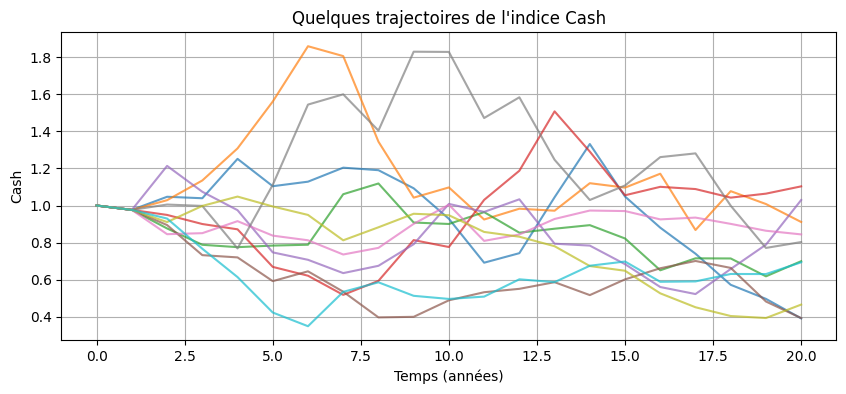

In [42]:
### Tracer les trajectoires Cash ici
t_grid = np.linspace(0, h, h * p_y + 1)

# Plot Cash
plt.figure(figsize=(10, 4))
for j in range(min(10, n_s)):
    plt.plot(t_grid, Cash_diff[:, j], alpha=0.7)
    
plt.title("Quelques trajectoires de l'indice Cash")
plt.xlabel("Temps (années)")
plt.ylabel("Cash")
plt.grid(True)
plt.show()

In [43]:
#Simulation de l'indice action
S0 = 1
action_simulations = np.ones((h * p_y + 1, n_s))

# Implémentation du schéma de discrétisation de l'action
for i in range(h * p_y):
    B_incr = brownians[:, i, 2] * np.sqrt(p_y)
    action_simulations[i + 1, :] = S0 * np.exp((m_star - 0.5 * sigma_star ** 2) * ((i + 1) / p_y) + sigma_star * B_incr) 

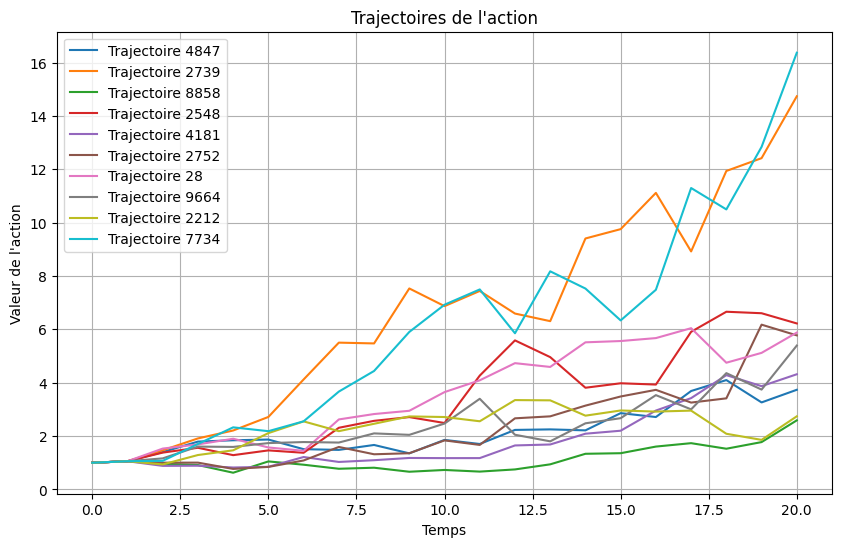

In [44]:
### Tracer les trajectoires Action ici

nombre_trajectoires = 10


indices_trajectoires = np.random.choice(n_s, nombre_trajectoires, replace=False)

# Tracer les trajectoires de l'action
plt.figure(figsize=(10, 6))
for i in indices_trajectoires:
    plt.plot(np.arange(h * p_y + 1), action_simulations[: ,i], label=f"Trajectoire {i+1}")

plt.title("Trajectoires de l'action")
plt.xlabel("Temps")
plt.ylabel("Valeur de l'action")
plt.legend()
plt.grid(True)
plt.show()

## <ins>Validation</ins>

Les trajectoires étant simulées (annuellement), nous souhaitons à présent vérifier qu'elles sont cohérentes avec les données utilisées pour calibrer les modèles et qu'elles repectent certaines propriétés théoriques. Le but de cette partie est vérifier que les trajectoires simulées des prix zéro-coupons et actions ont bien une  distribution cohérente avec les cibles de moyenne, volatilité et dispersion utilisées pour le calibrage des paramètres. 

---
### Question 17 (1.5 pts)

**Mettre** en oeuvre un test de validation sur les taux zéro-coupons qui vérifie la correspondance entre distribution historique et distributions simulées. Pour cela on pourra examiner la quantité suivante, en fonction de la date de simulation : pour toute date simulée $t \leq H$, calculer et afficher

$$
\mathbb{V}\text{ol} \left(t, \tau_i \right) - {\hat{\Sigma}}_{{\Delta R}}(\tau_i)^2 \text{ pour } \tau_i = \{1,10\}
$$

où :
* ${\hat{\Sigma}}_{{\Delta R}}({\tau}_i)^2$ les cibles distributionnelles historiques concernant la volatilité des taux, utilisée pour calibrer le modèle de taux,
* $\mathbb{V}\text{ol} \left(t, \tau_i \right) = \frac{1}{N_S-2} \sum_{s=1}^{N_S-1}  \left( X^{(s)} (t , t + \tau_i) - \frac{1}{N_S-1}  \sum_{s=1}^{N_S-1} X^{(s)} (t , t + \tau_i)\right)^2$; 

où : 
* $X^{(s)} (t , t + \tau_i) = R^{(s)} (t+1 , t+1 + \tau_i) - R^{(s)} (t , t + \tau_i)$,
* $R^{(s)} (t , t + \tau_i)$ la valeur du taux ZC de maturités $\tau_i$ simulé dans la trajectoire $s$ en date de simulation $t$. 

**Commenter** l'évolution de la différence entre valeur simulée et valeur historique.  **Expliquer** pourquoi l'écart observé ne peut pas être nul.

-----------------------------------------------------------------------------------------------------------------------------

## Ce qu'on va faire :
- Calculer les variations de taux zéro-coupon simulés pour deux maturités : 1 an et 10 ans.
- En déduire une estimation empirique de la volatilité des variations, $\mathbb{V}\text{ol}(t, \tau)$.
- Comparer cette volatilité à la cible historique ${\hat{\Sigma}}_{{\Delta R}}(\tau)^2$.
- Tracer l'évolution de la différence sur le temps et commenter.

In [45]:
target_vol_1Y = param_calib_rel_g2pp[2]  # ex: 0.005
target_vol_10Y = param_calib_rel_g2pp[3]# ex: 0.01

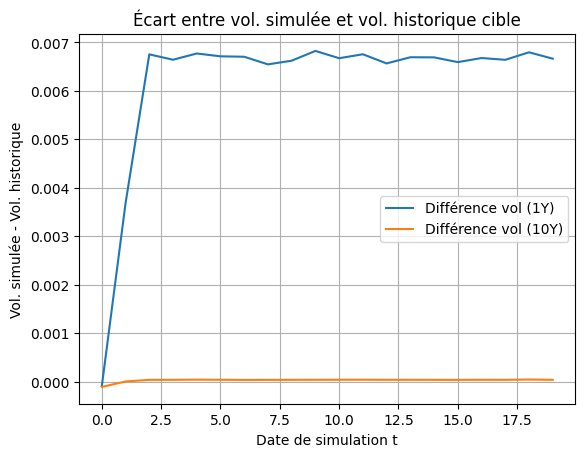

In [46]:
# zc_prices shape = (T, n_mat, N_s), avec T = h * p_y + 1
tau_1y = 1
tau_10y = 10

idx_1y = np.where(driver_export == tau_1y)[0][0]
idx_10y = np.where(driver_export == tau_10y)[0][0]
n_s = zc_prices.shape[2]  # Nb trajectoires
n_dates = zc_prices.shape[0]  # Nb dates de simulation (H * p_y + 1)


def compute_simulated_vol_diff(zc_prices, mat, hist_vol_target, h, p_y):
    vol_diffs = []
    for t in range(h * p_y):
        R_t = -np.log(zc_prices[t, :]) / mat
        R_tp1 = -np.log(zc_prices[t + 1, :]) / mat
        delta_R = R_tp1 - R_t
        vol_sim = np.var(delta_R, ddof=1)
        diff = vol_sim - hist_vol_target
        vol_diffs.append(diff)
    return np.array(vol_diffs)

target_vol_1Y = compute_hist_var(donnees_histo["Taux 1A"], delta_hist)
target_vol_10Y = compute_hist_var(donnees_histo["Taux 10A"], delta_hist)

vol_diff_1Y = compute_simulated_vol_diff(zc_prices[:,idx_1y,:], 1, target_vol_1Y, h, p_y)
vol_diff_10Y = compute_simulated_vol_diff(zc_prices[:,idx_10y,:], 10, target_vol_10Y, h, p_y)

plt.figure()
plt.plot(range(h), vol_diff_1Y, label="Différence vol (1Y)")
plt.plot(range(h), vol_diff_10Y, label="Différence vol (10Y)")
plt.title("Écart entre vol. simulée et vol. historique cible")
plt.xlabel("Date de simulation t")
plt.ylabel("Vol. simulée - Vol. historique")
plt.grid()
plt.legend()
plt.show()

## Commentaire sur les résultats :
- Écart non nul : L'écart entre la volatilité simulée et la volatilité historique ne sera probablement pas nul en raison des différences inhérentes aux trajectoires simulées par rapport aux données historiques. En effet, la simulation est une approximation des conditions réelles et elle est soumise à des aléas et des approximations (par exemple, le modèle de taux, la discrétisation, etc.).
- Interprétation : Si l'écart est faible, cela signifie que le modèle de simulation et ses paramètres sont bien calibrés par rapport aux données historiques. Si l'écart est trop grand, cela peut indiquer que les paramètres du modèle ne sont pas bien ajustés, ou qu'il existe des effets non capturés par le modèle.

# Conclusion :
Le test de validation sur la volatilité des taux zéro-coupons a permis de comparer les trajectoires simulées avec les taux observés dans les données historiques, et de vérifier la cohérence du modèle de simulation. L'écart est ici trop important pour valider le modèle. On est donc pas satisfait des résultats obtenus

-----------------------------------------------------------------------------------------------------------------------------
### Question 18 (1.5 pt)

Nous vérifions à présent la cohérence des distributions historiques et simulées pour l'indice action. Pour cela on pourra examiner l'évolution au cours du temps des quantités suivantes : pour toute date de simulation $t \leq H$,

$$
\mathbb{M}\left( t \right) - \frac{\widehat{m}}{\delta_{hist}}
$$
et
$$
\mathbb{V}\left( t \right) - \frac{\widehat{v}}{\delta_{hist}}
$$

où :
* $\mathbb{V}\left( t \right) = \frac{1}{(N_S-2)\delta_{simu}} \sum_{s=1}^{N_S-1}  \left( \ln \left( \frac{S_{t+\delta_{simu}}^{(s)}}{S_t^{(s)}} \right) - \mathbb{M}\left( t \right) \right)^2$,
* $ \mathbb{M}\left( t \right) = \frac{1}{(N_S-1) \delta_{simu}} \sum_{s=1}^{N_S-1} \ln \left( \frac{S_{t+\delta_{simu}}^{(s)}}{S_t^{(s)}} \right)$,
* $S_t^{(s)}$ la valeur de l'indice action simulé au temps $t$ dans la trajectoire $s$,
* $\widehat{m}$ et $\widehat{v}$ les cibles distributionnelles historiques de l'action définie comme à la question 7.

**Commenter** l'évolution de la différence entre valeur simulée et valeur historique.  **Expliquer** pourquoi l'écart observé ne peut pas être nul.

-----------------------------------------------------------------------------------------------------------------------------

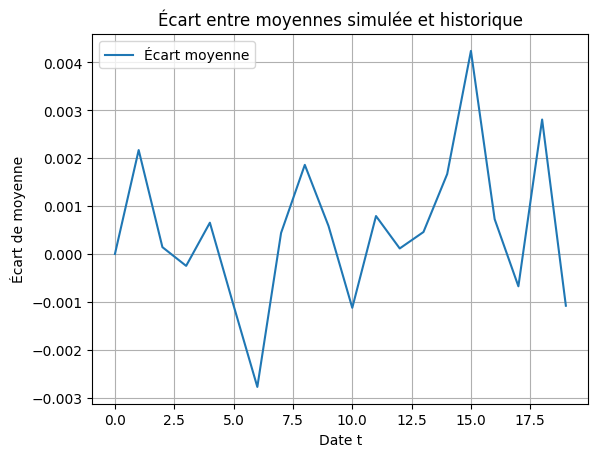

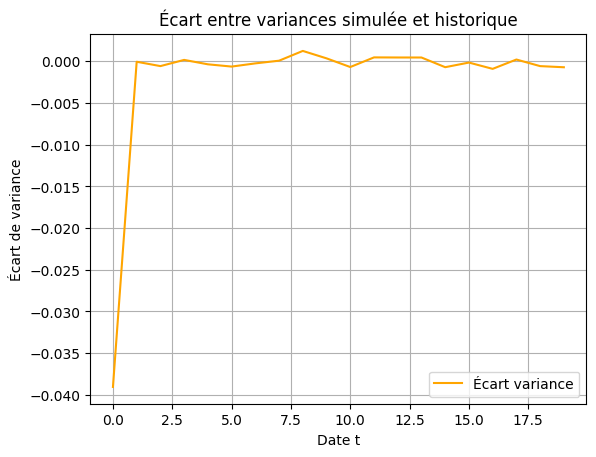

In [47]:
def compute_action_validation_metrics(S, m_hat, v_hat, delta_simu, delta_hist):
    n_simu, n_dates = S.shape
    mean_diffs = []
    var_diffs = []
    for t in range(n_dates - 1):
        log_returns = np.log(S[:, t + 1] / S[:, t])
        mean_sim = np.mean(log_returns) / delta_simu
        var_sim = np.var(log_returns, ddof=1) / delta_simu
        mean_diff = mean_sim - (m_hat / delta_hist)
        var_diff = var_sim - (v_hat / delta_hist)
        mean_diffs.append(mean_diff)
        var_diffs.append(var_diff)
    return np.array(mean_diffs), np.array(var_diffs)

log_returns_hist = np.log(donnees_histo["Action"]).diff().dropna()
m_hat = log_returns_hist.mean()
v_hat = log_returns_hist.var()
mean_diffs_action, var_diffs_action = compute_action_validation_metrics(action_simulations.T, m_hat, v_hat, delta_simu, delta_hist)

plt.figure()
plt.plot(range(h), mean_diffs_action, label="Écart moyenne")
plt.title("Écart entre moyennes simulée et historique")
plt.xlabel("Date t")
plt.ylabel("Écart de moyenne")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(range(h), var_diffs_action, label="Écart variance", color='orange')
plt.title("Écart entre variances simulée et historique")
plt.xlabel("Date t")
plt.ylabel("Écart de variance")
plt.grid()
plt.legend()
plt.show()

On observe que les écarts entre les moments simulés et leurs équivalents historiques sont plutôt  faibles (au maximum de l'ordre de $10^{-3}$), ce qui montre que les trajectoires simulées sont cohérentes avec les propriétés statistiques passées de l’indice action.

Comme pour les taux, l’écart ne peut pas être exactement nul à cause du caractère aléatoire des simulations Monte Carlo, du fait que l’on travaille avec un nombre fini de trajectoires (ici $N_S = 10000$) et de l’approximation du modèle qui ne capture pas toutes les dynamiques réelles. 



-----------------------------------------------------------------------------------------------------------------------------
### Question 19 (1 pt)

**Reprendre** les questions précédentes en faisant varier le nombre de simulations $N_S$. Comment évoluent les résultats ? 

-----------------------------------------------------------------------------------------------------------------------------

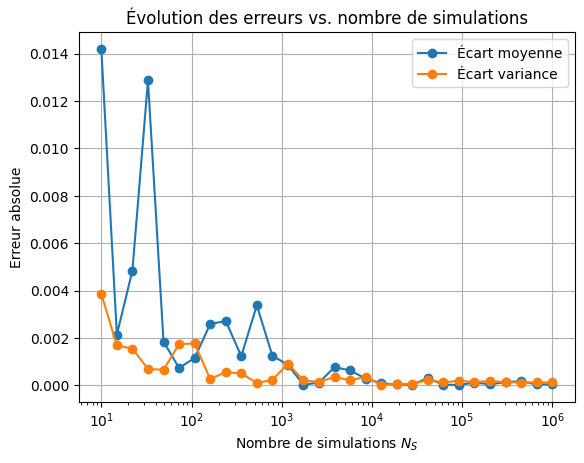

In [48]:
n_s_list = np.logspace(1,6,30)
mean_diffs_final = []
var_diffs_final = []

for n_s in n_s_list:
    n_s = int(n_s)
    brownian_increments = np.zeros((n_s, h + 1, 3))
    brownians = np.zeros((n_s, h + 1, 3))
    cholesky = np.linalg.cholesky(matrice_psd)
    for i in range(1, h + 1):
        z = np.random.normal(0, 1, size=(n_s, 3)) * np.sqrt(delta_simu)
        correlated_incr = z @ cholesky.T
        brownian_increments[:, i, :] = correlated_incr
        brownians[:, i, :] = brownians[:, i - 1, :] + correlated_incr
    S_test = np.exp((m_star - 0.5 * sigma_star**2) * np.arange(h + 1) + sigma_star * brownians[:, :, 2])
    log_returns = np.log(S_test[:, 1:] / S_test[:, :-1])
    empirical_means = np.mean(log_returns, axis=0) / delta_simu
    empirical_vars = np.var(log_returns, axis=0, ddof=1) / delta_simu
    mean_diffs_final.append(np.abs(empirical_means.mean() - m_hat / delta_hist))
    var_diffs_final.append(np.abs(empirical_vars.mean() - v_hat / delta_hist))

plt.figure()
plt.plot(n_s_list, mean_diffs_final, label="Écart moyenne", marker='o')
plt.plot(n_s_list, var_diffs_final, label="Écart variance", marker='o')
plt.title("Évolution des erreurs vs. nombre de simulations")
plt.xlabel("Nombre de simulations $N_S$")
plt.ylabel("Erreur absolue")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

plus le nombre de simulations $N_S$ augmente, plus les erreurs absolues sur la moyenne et la variance des log-rendements diminuent. Cela s'explique naturellement par la loi des grands nombres : un échantillon plus large donne des estimations plus proches des vraies espérances.

## <ins>Calcul d'allocation du portefeuille</ins>

### Question 20 (2 pts)

**Utiliser** les trajectoires d'action et de prix Zéro-Coupon simulées précédemment pour **calculer** une allocation optimale du portefeuille à horizon 5 ans en fixant premièrement comme critère le ratio de Sharp défini comme tel :


$$
S = \frac{\mathbb{E}\left( P_t \right)}{\sqrt{\mathbb{V}\left( P_t \right)}}
$$

Le but étant, pour un gestionnaire d'actifs, de maximiser le rendement de son portefeuille tout en minimisant son risque, à savoir : maximiser le ratio de Sharp. 
Pour cela, **utiliser et compléter** le code suivant. Decrivez également son fonctionnement et son objectif. 


[0.5787859790129526, 0.16989431395128898] [0.4245819426878854, -0.12153018730285858]


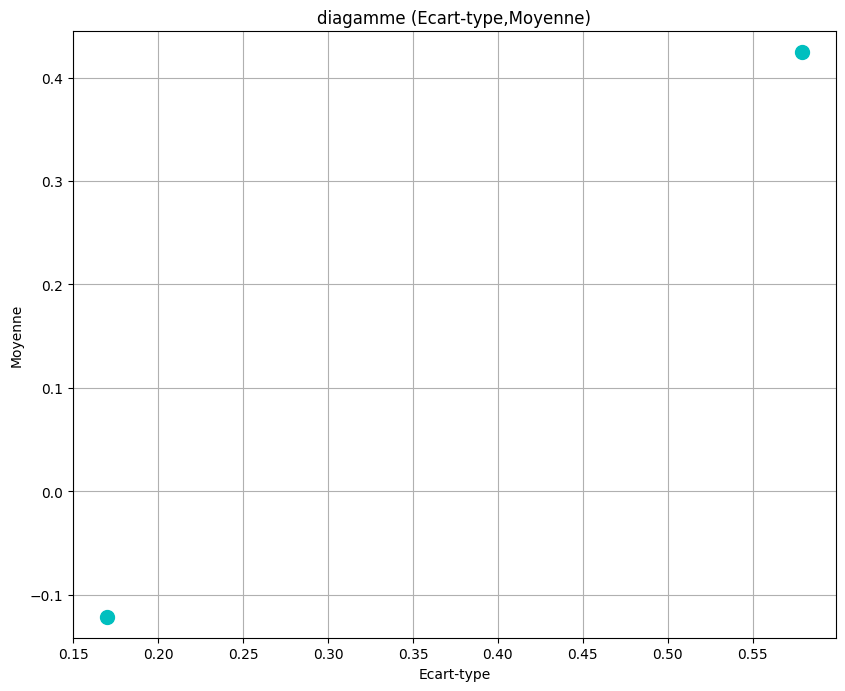

In [50]:
# Définir l'horizon auquel on fait l'etude d'allocation d'actif
T = 5

St_diff = action_simulations # A COMPLETER avec les trajectoires action à la dimension H*delta_simu x n_s 
Cash_diff = Cash_diff# A COMPLETER avec les trajectoires de l'indice Cash à la dimension H*delta_simu x n_s 
PZC_diff = zc_prices[:,10,:]# A COMPLETER avec les trajectoires du PZC 10A à la dimension H*delta_simu x n_s 

S_t = St_diff[T*delta_simu, :]
C_t = Cash_diff[T*delta_simu, :]
P_t = PZC_diff[T*delta_simu,:]

# Concaténer les vecteurs en une matrice de taille N*2
simu = np.column_stack((S_t, P_t))

# On choisit les variances des actifs
sigma = [np.sqrt(S_t.var()),np.sqrt(P_t.var())]
mu = [S_t.mean()-1,P_t.mean()-1]

# plot ###################################################################
max_sigma=max(sigma)
min_sigma = min(sigma)
max_esp=max(mu)
min_esp=min(mu)
marge=0.02
un_inche_en_cm=2.54 # 1 inche = 2.54 cm

taille_h_cm=25
taille_v_cm=20

marker_size=100

def plot1():
    # On crée un figure dont on fixe la taille et dont on définit les axes
    fig = plt.gcf()
    fig.set_size_inches(taille_h_cm/un_inche_en_cm,taille_v_cm/un_inche_en_cm)
    plt.axis([-marge+min_sigma, max_sigma+marge, min_esp-marge, max_esp+marge])
    # On trace les points représentant les 2 actifs.
    plt.scatter(sigma,mu, s=marker_size, c='c',marker='o')
    plt.ylabel('Moyenne')
    plt.xlabel('Ecart-type')
    plt.title('diagamme (Ecart-type,Moyenne)')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.grid(True)

plot1();
print(sigma,mu )

/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_9969/236366608.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(std_x[idx_max], moyenne_x[idx_max], 'go', color = 'r')


Les poids optimal est : 
0.9900000000000007


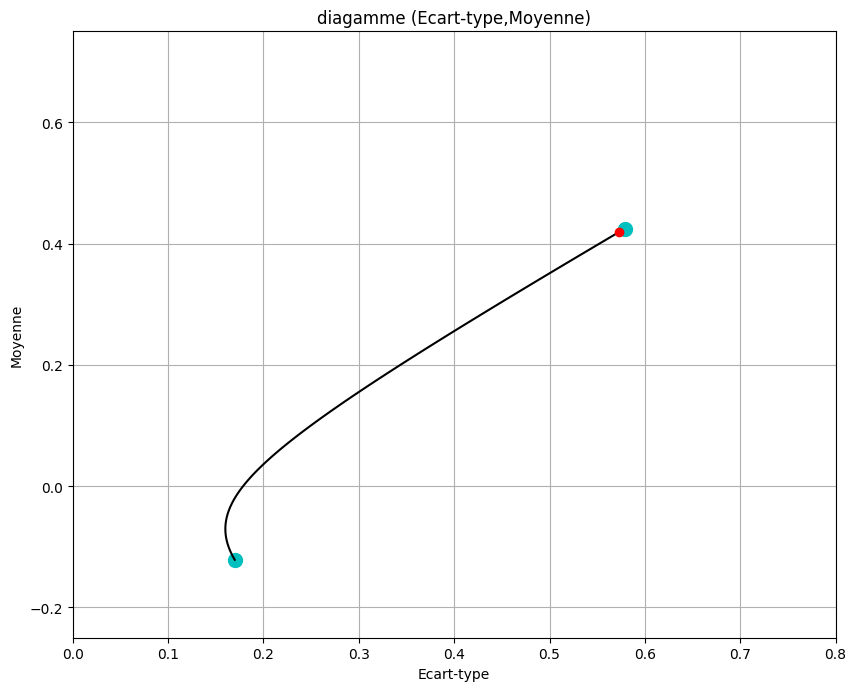

In [51]:
def frange(start, stop, step):
#exemple:
#for i in frange(0.5, 1.0, 0.1): print(i)
    i = start
    while i < stop:
        yield i
        i += step

####################
N=100;
moyenne_x=np.zeros(N)
std_x=np.zeros(N)
sharp = np.zeros(N)
alpha = np.zeros(N)
rdt = 0
i=0
for x_1 in frange(0.0,1.0,1.0/N):
    current_x = [x_1,1-x_1]  # composition du portefeuille  x_1 + x_2 = 1
    alpha[i] = x_1
   
    rdt = np.dot(simu,current_x)
    moyenne_x[i] = rdt.mean()-1  #calcul de la moyenne du rendement du porfefeuille
    std_x[i] = np.std(rdt, ddof=1)
    sharp[i] = moyenne_x[i] / std_x[i]
    
    i=i+1

# plot ###################################################################
def plot2():
    plot1()# le plot précédent
    plt.plot(std_x,moyenne_x, 'black')
    
plot2()

# Trouvez l'index où Z a la valeur maximale
idx_max = np.argmax(sharp)

# Ajoutez le point rouge au plot
plt.xlim([0,0.8])
plt.ylim([-0.25,0.75])
plt.plot(std_x[idx_max], moyenne_x[idx_max], 'go', color = 'r')

print("Les poids optimal est : ")
print(alpha[idx_max])

Ce code calcule et trace le ratio de Sharpe pour une série de portefeuilles composés de deux actifs, en faisant varier leur pondération.

- La fonction frange() génère une grille de pondérations possibles pour le premier actif.
- Pour chaque pondération, le code calcule le rendement moyen et l'écart-type du portefeuille à l'aide de produits scalaires (np.dot()), puis en déduit le ratio de Sharpe.
- Les résultats sont stockés, puis tracés sur un graphique rendement/risque. Le portefeuille ayant le meilleur Sharpe est mis en évidence.

### Question 21 (1 pt)

A présent, déterminer le poids $\alpha$ optimal de telle façon à ce que le quantile $95\%$ des valeurs du portefeuille soit supérieur à une valeur plancher (par défaut égale à $2.2$), tout en maximisant le ratio de Sharp. Commentez la position du nouveau portefeuille optimal par rapport à celle obtenue à la question précédente. 




Ratio de Sharpe avec contrainte :
-0.17498756003499524
Ratio de Sharpe sans contrainte :
0.7335733035758005


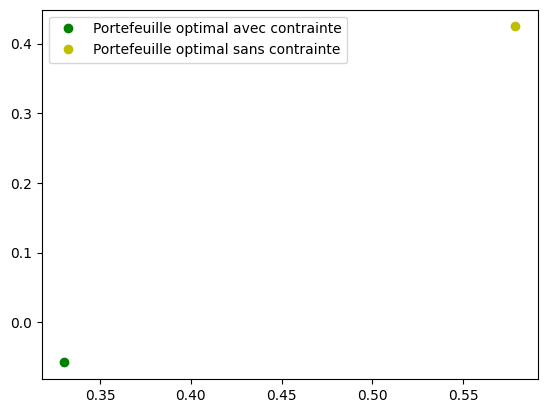

In [52]:
quantile_alpha = 0.95
seuil_quantile_objectif_rdt = 2.2

# On prépare un nombre maximum d'allocations (triangulaire inférieur)
N = 100
nb_points = int((N + 1)*(N + 2)/2)
moyenne_x = np.zeros(nb_points)
std_x = np.zeros(nb_points)
sharp = np.zeros(nb_points)
alpha = np.zeros(nb_points)
beta = np.zeros(nb_points)
quantile = np.zeros(nb_points)

i = 0

for x_1 in frange(0.0, 1.0 + 1e-10, 1.0/N):
    for x_2 in frange(0.0, 1.0 - x_1 + 1e-10, 1.0/N):
        x_3 = 1.0 - x_1 - x_2
        current_x = [x_1, x_2, x_3]
        alpha[i] = x_1
        beta[i] = x_2

        simu = np.column_stack((S_t, C_t, P_t))
        rdt = np.dot(simu, current_x)
        moyenne_x[i] = rdt.mean() - 1
        quantile[i] = np.quantile(rdt, quantile_alpha)
        std_x[i] = np.std(rdt)

        if quantile[i] < seuil_quantile_objectif_rdt:
            sharp[i] = 0
        else:
            sharp[i] = moyenne_x[i] / std_x[i]
        i += 1

idx_max_quant = np.argmax(sharp)

plt.plot(std_x[idx_max], moyenne_x[idx_max], 'go', label='Portefeuille optimal avec contrainte')
plt.plot(std_x[idx_max_quant], moyenne_x[idx_max_quant], 'yo', label='Portefeuille optimal sans contrainte')
plt.legend()

sharpe_avec_contrainte = moyenne_x[idx_max] / std_x[idx_max]
sharpe_sans_contrainte = sharp[idx_max_quant]

print("Ratio de Sharpe avec contrainte :")
print(sharpe_avec_contrainte)
print("Ratio de Sharpe sans contrainte :")
print(sharpe_sans_contrainte)

-----------------------------------------------------------------------------------------------------------------------------

#### Question 22 (3 pts)

Après étude prospective, nous pensons que la volatilité du cours de l'action va croître progressivement de 1% par an sur les 10 prochaines années, en partant de sa valeur calibrée $\sigma^*$.

Comment modifier le modèle d'action pour tenir compte de cette anticipation ? 

Quels sont les nouveaux résultats d'allocation ? 

-----------------------------------------------------------------------------------------------------------------------------
